================================================================================================

Program ini dibuat untuk melakukan customer segmentation menggunakan model clustering dari data kartu kredit perbankan selama 6 bulan terakhir yang diperoleh dari google bigquery. Selanjutnya data hasil clustering customer dianalisa untuk menghasilkan insight dan rekomendasi bisnis ke setiap cluster dengan tepat.

================================================================================================

# Query SQL

Pada bagian ini akan dilakukan query data menggunakan SQL, sebelumnya query dilakukan pada google collab lalu dipindahkan ke VSCODE.

In [51]:
# melakukan autentikasi ke database bigquery
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')
project_id = "stoked-depth-432504-q5"
client = bigquery.Client(project=project_id)

# mengambil data
df = client.query('''
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_020_hck.credit-card-information`
WHERE MOD(CUST_ID, 2) = 0;
''').to_dataframe()

# menyimpan data ke csv
df.to_csv('P1G6_Set_1_ciputra_wangsa.csv', index=False)

# Import Library

Pada bagian ini dilakukan import libraries yang akan digunakan dalam pembuatan program clustering.

In [52]:
# Dataframe and Data Manipulation library
import pandas as pd
import numpy as np

# Visualization Library
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Model
from sklearn.cluster import KMeans

# Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer
import matplotlib.cm as cm

# Silhouette Analysis
from sklearn.metrics import silhouette_score,silhouette_samples

# Save Model
import json
import pickle

# Identifikasi Masalah

## Topik Permasalahan

Membuat clustering customer segmentation untuk mempertahankan dan meningkatkan layanan perusahaan PT Rumah Baru Keluarga.

## Latar Belakang Masalah

Perusahaan Bank ABC ingin meningkatkan efektivitas strategi marketing dengan menyegmentasi nasabah berdasarkan pola penggunaan kartu kredit selama 6 bulan terakhir. Dengan Customer Segmentation, tim marketing dapat lebih tepat menargetkan nasabah sesuai preferensi mereka, meningkatkan loyalitas, dan profitabilitas. Untuk itu, customer segmentation perlu dilakukan untuk membentuk kelompok nasabah yang karakteristik penggunaan kartu kreditnya mirip dan memberikan rekomendasi bisnis yang sesuai untuk setiap segmen.

## Problem Statement (SMART FRAMEWORK)

S (Specific): Mengelompokkan nasabah berdasarkan pola penggunaan kartu kredit.

M (Measurable): Minimal 3 cluster customer terbentuk.

A (Achievable): Menggunakan model clustering KMeans untuk segmentasi.

R (Relevant): Menggunakan model KMeans sangat relevan untuk mendapatkan minimal 3 cluster dan memberikan rekomendasi bisnis ke setiap cluster secara tepat sesuai karakteristik setiap cluster yang terbentuk.

T (Time-bound): Pembentukan segmentasi customer dilaksanakan dalam 1 minggu.

**Problem Statement:** Mengelompokkan nasabah kartu kredit Bank ABC menggunakan model clustering KMeans berdasarkan pola penggunaan kartu kredit selama 6 bulan terakhir, dengan tujuan untuk mengidentifikasi minimal 3 cluster customer dan untuk memberikan rekomendasi bisnis ke setiap segment secara tepat sesuai karakteristik setiap segment berdasarkan cluster yang terbentuk dalam kurun waktu 1 minggu.

## Rumusan Masalah

1. Apakah terdapat pola antara pengaruh TENURE dengan variabel PURCHASES, BALANCE, dan PAYMENTS ?
2. Apakah nasabah dengan CREDIT_LIMIT yang tinggi cenderung lebih sering melakukan pembelian ? 
3. Apakah nasabah dengan CREDIT_LIMIT yang tinggi cenderung lebih sering melakukan cash_advance ? 

# Data Loading

Pada bagian ini berisi load data csv, head data, tail data, informasi dataset, deskripsi nama kolom, pengecekan data duplikat dan missing value.

## Load Data CSV

In [53]:
# load data csv menggunakan fungsi .read_csv()
df = pd.read_csv('P1G6_Set_1_ciputra_wangsa.csv')

## Load 10 Baris Teratas Dataset

In [94]:
# menampilkan 5 baris teratas dataset menggunakan fungsi .head()
df.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0      788    16.581535           0.555556      200.0              0.00   
1     1902   943.584041           0.875000      103.0            103.00   
2     2322     1.979916           0.555556       80.0             80.00   
3     3426   461.455720           1.000000      585.0            585.00   
4     3976  1053.594730           1.000000     1450.0           1450.00   
5     4266  2237.238086           1.000000      120.0            120.00   
6     4360  2730.843802           1.000000     2900.0           2321.28   
7     4680   424.994385           0.555556     1200.0           1200.00   
8     5884    18.885677           0.555556       57.0             57.00   
9       24     0.004816           0.555556       51.7              0.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   200.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
6                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   
8                     0.0           0.0                0.125   
9                    51.7           0.0                0.250   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000                             0.125   
1                       0.125                             0.000   
2                       0.125                             0.000   
3                       0.125                             0.000   
4                       0.125                             0.000   
5                       0.125                             0.000   
6                       0.125                             0.000   
7                       0.125                             0.000   
8                       0.125                             0.000   
9                       0.000                             0.250   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              2        1200.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
6                     0.0                 0              1        2900.0   
7                     0.0                 0              1        1200.0   
8                     0.0                 0              1        1500.0   
9                     0.0                 0              3        3000.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0    0.000000        309.854995               0.0       8  
1  215.325023        410.484825               0.0       8  
2    0.000000        309.854995               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8  
5  343.102984        712.986387               0.0       8  
6    0.000000        309.854995               0.0       8  
7   57.266292         56.720210               0.0       8  
8    0.000000        309.854995               0.0       8  
9   33.249088          0.059481               0.0      12

Dari output diatas didapatkan informasi bahwa keseluruhan data kolom dataset berisi numerik, dan ada missing value di kolom minimum payments sehingga nanti akan dicek lebih lanjut dan akan dihandling.

## Load 10 Baris Terbawah Dataset

In [95]:
# menampilkan 5 baris terbawah dataset menggunakan fungsi .tail()
df.tail(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
4465     1588   538.768762           0.909091     226.95            129.58   
4466     6900  7468.012010           1.000000    1569.41            796.07   
4467     2528   427.642111           0.888889       0.00              0.00   
4468     1226   706.327578           0.888889     169.54            169.54   
4469     2152  1420.727073           1.000000       0.00              0.00   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4465                   97.37    452.009130             0.545455   
4466                  773.34   4394.279848             0.545455   
4467                    0.00   2563.705644             0.000000   
4468                    0.00   1406.735573             0.333333   
4469                    0.00    311.804499             0.000000   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4465                    0.090909                          0.454545   
4466                    0.454545                          0.363636   
4467                    0.000000                          0.000000   
4468                    0.333333                          0.000000   
4469                    0.000000                          0.000000   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4465                0.272727                 8              9        1200.0   
4466                0.272727                 7             10        8700.0   
4467                0.727272                16              0        1200.0   
4468                0.727272                14              3        2500.0   
4469                0.727272                 9              0        1500.0   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                16             25        6000.0   
4474                0.545455                16             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4465   946.649324        211.220001          0.000000      11  
4466  2162.943350       2652.464173          0.000000      11  
4467  2853.967334        146.976542          0.500000       9  
4468   302.976780        142.597254          0.000000       9  
4469   506.765033        449.179818          0.000000      10  
4470  1379.635287        271.364415          0.090909      11  
4471  4372.148648        241.645387          0.090909      11  
4472  1039.000037        886.050237          0.000000      11  
4473   905.844846       2376.919568          0.090909      11  
4474  3056.424974        910.707525          0.090909      11

Dari output diatas didapatkan informasi bahwa keseluruhan data kolom dataset terisi dengan baik sampai bawah, tetapi nanti akan dicek lebih lanjut terkait missing valuenya.

## Menampilkan Summary Informasi Dataset

In [56]:
# menampilkan summary info dataset menggunakan fungsi .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

Dari output diatas didapatkan informasi bahwa dari dataset terdapat 4475 baris data, 18 kolom dan ada missing value di kolom credit_limit dan minimum_payments

## Deskripsi Kolom Dataset

In [57]:
# menampilkan nama kolom dataset menggunakan fungsi .columns()
df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')


| Column name | Description |
|-------------|-------------|
| CUST_ID | Identification of Credit Card holder |
| PURCHASES | Amount of purchases made from account|
| BALANCE | Balance amount left in their account to make purchases |
| BALANCE FREQUENCY | How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0= not frequently updated) |
| ONEOFF PURCHASES | Maximum purchase amount done in one-go |
| INSTALLMENTS_PURCHASES | Amount of purchase done in installment |
| CASH_ADVANCE | Cash in advance given by the user |
| PURCHASES_FREQUENCY | How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) |
| ONEOFF PURCHASES_FREQUENCY | How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) |
| PURCHASES_INSTALLMENTS_FREQUENCY | How frequently purchases in installments are being done (1= frequently done, 0 = not frequently done) |
| CASH_ADVANCE_FREQUENCY | How frequently the cash in advance being paid |
| CASH_ADVANCE_TRX | Number of Transactions made with 'Cash in Advanced' |
| PURCHASES_TRX | Number of purchase transactions made |
| CREDIT_LIMIT | Limit of Credit Card for user |
| PAYMENTS | Amount of Payment done by user |
| MINIMUM_PAYMENTS | Minimum amount of payments made by user |
| PRC_FULL_PAYMENT | Percent of full payment paid by user |
| TENURE | Tenure of credit card service for user |

## Melakukan Pengecekan Data Duplikat

In [58]:
# melakukan pengecekan data duplikat menggunakan fungsi .duplicated().sum()
df.duplicated().sum()

0

Dari output diatas didapatkan informasi bahwa tidak ada data yang terduplikasi dalam dataset.

## Melakukan Pengecekan Missing Value

In [59]:
# melakukan pengecekan data duplikat menggunakan fungsi .isna().sum()
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Dari output diatas didapatkan informasi bahwa terdapat 1 missing value di kolom credit_limit dan 158 missing value pada kolom minimum_payments, sehingga akan dihandling saat feature engineering.

# Exploratory Data Analysis (EDA)

Pada bagian ini berisi heatmap korelasi kolom numerikal, pengecekan distribusi data, analisa missing value, melihat pengaruh tenure dengan kolom purchase, balance, payments, dan melihat apakah nasabah yang memiliki credit limit besar cenderung memiliki purchase frequenct yang besar juga.

## Memisahkan Kolom Berdasarkan Tipe Data

In [60]:
# kolom numerikal
num_col = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']

# kolom kategorikal
cat_col = ['TENURE']

## Heatmap Kolom Numerikal

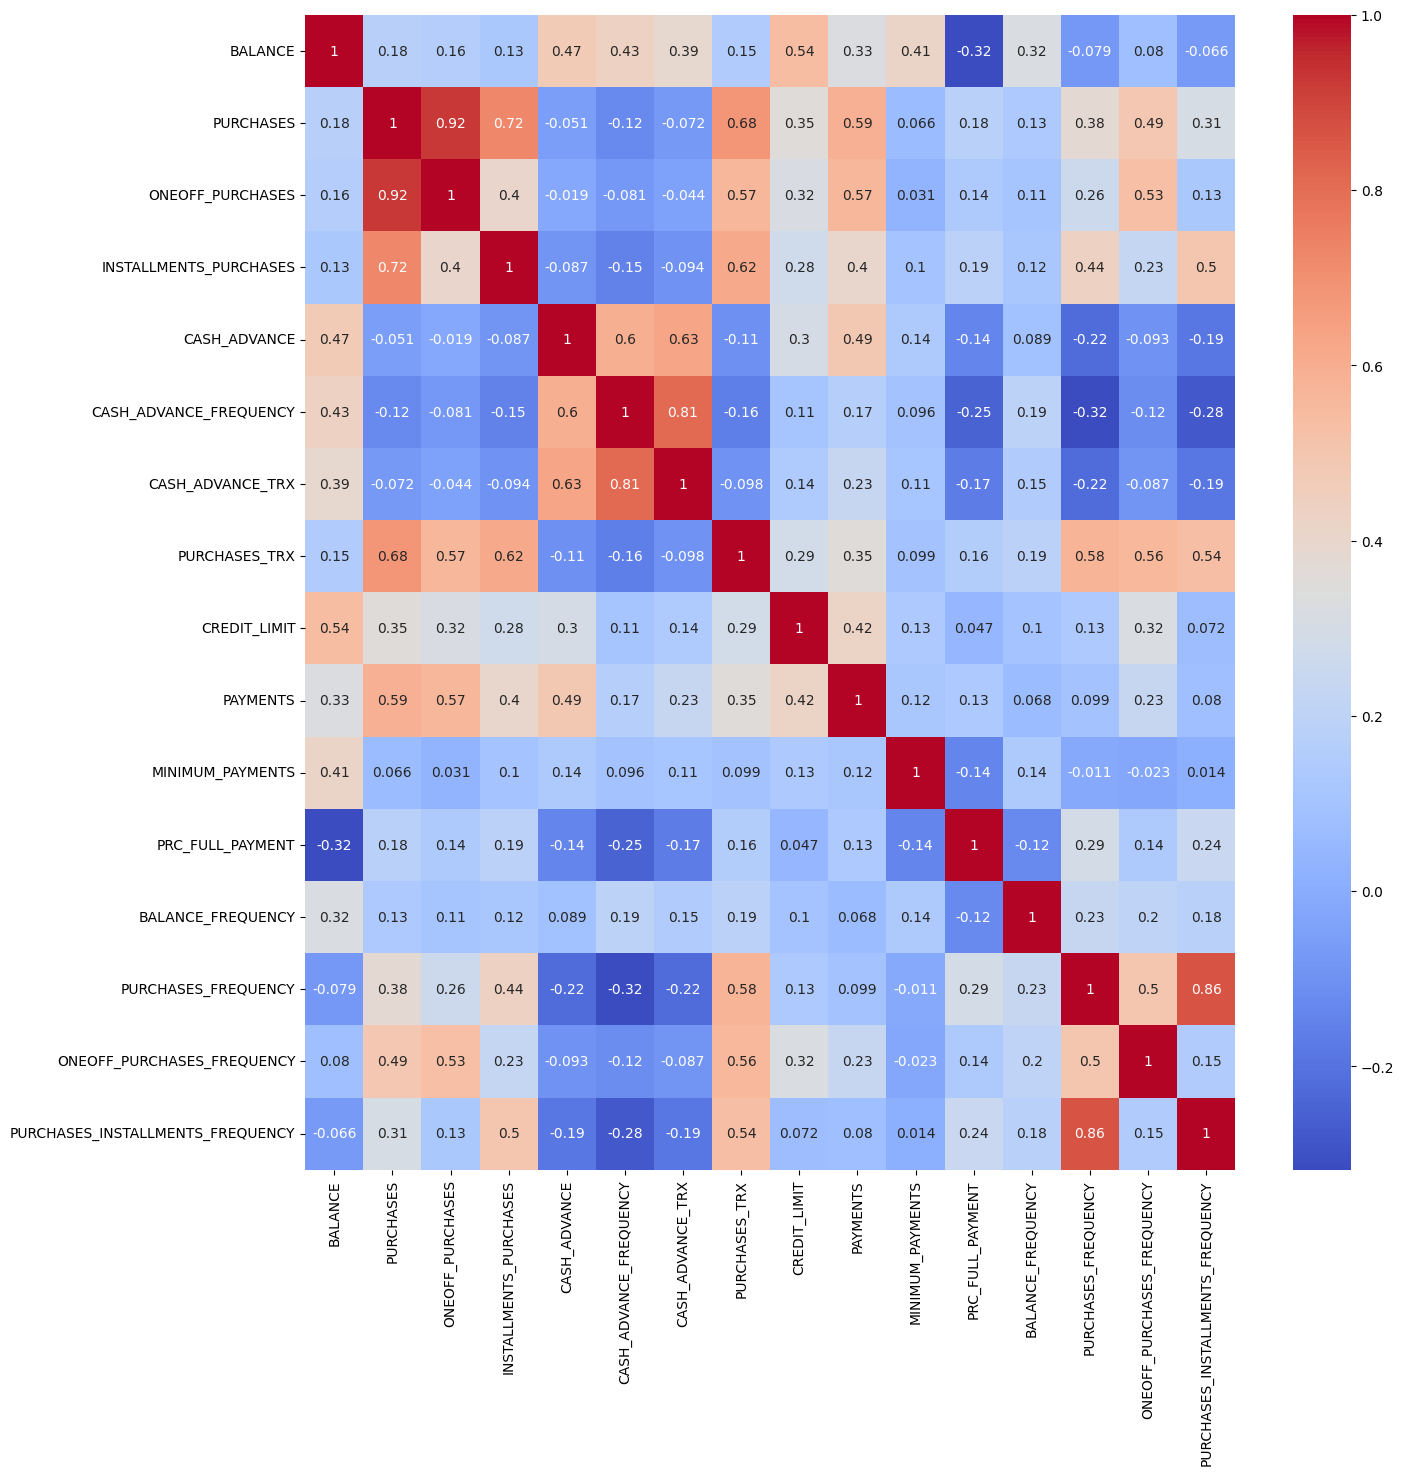

In [61]:
# membuat size canvas
plt.figure(figsize=(15, 15))

# Membuat heatmap
sns.heatmap(df[num_col].corr(), annot=True, cmap='coolwarm')

# menampilkan heatmap
plt.show()

Dari output diatas didapatkan informasi bahwa:

- Beberapa kolom memiliki korelasi tinggi karena kolom tersebut berkaitan dengan hubungan dengan kolom itu sendiri, misalnya purchases_trx dengan purchases dan cash_advance_trx dengan cash_advance, kolom oneoff_purchases dan installments_purchases dengan kolom purchases sehingga tidak akan terlalu berfokus pada korelasi kolom tersebut.
- Credit_limit dan balance cukup memiliki korelasi positif yang kuat, berarti jika diasumsikan, artinya banyak pengguna yang limit kartu semakin tinggi kartunya jarang digunakan.


## Melihat Distribusi dan Karakteristik dari Data Kolom

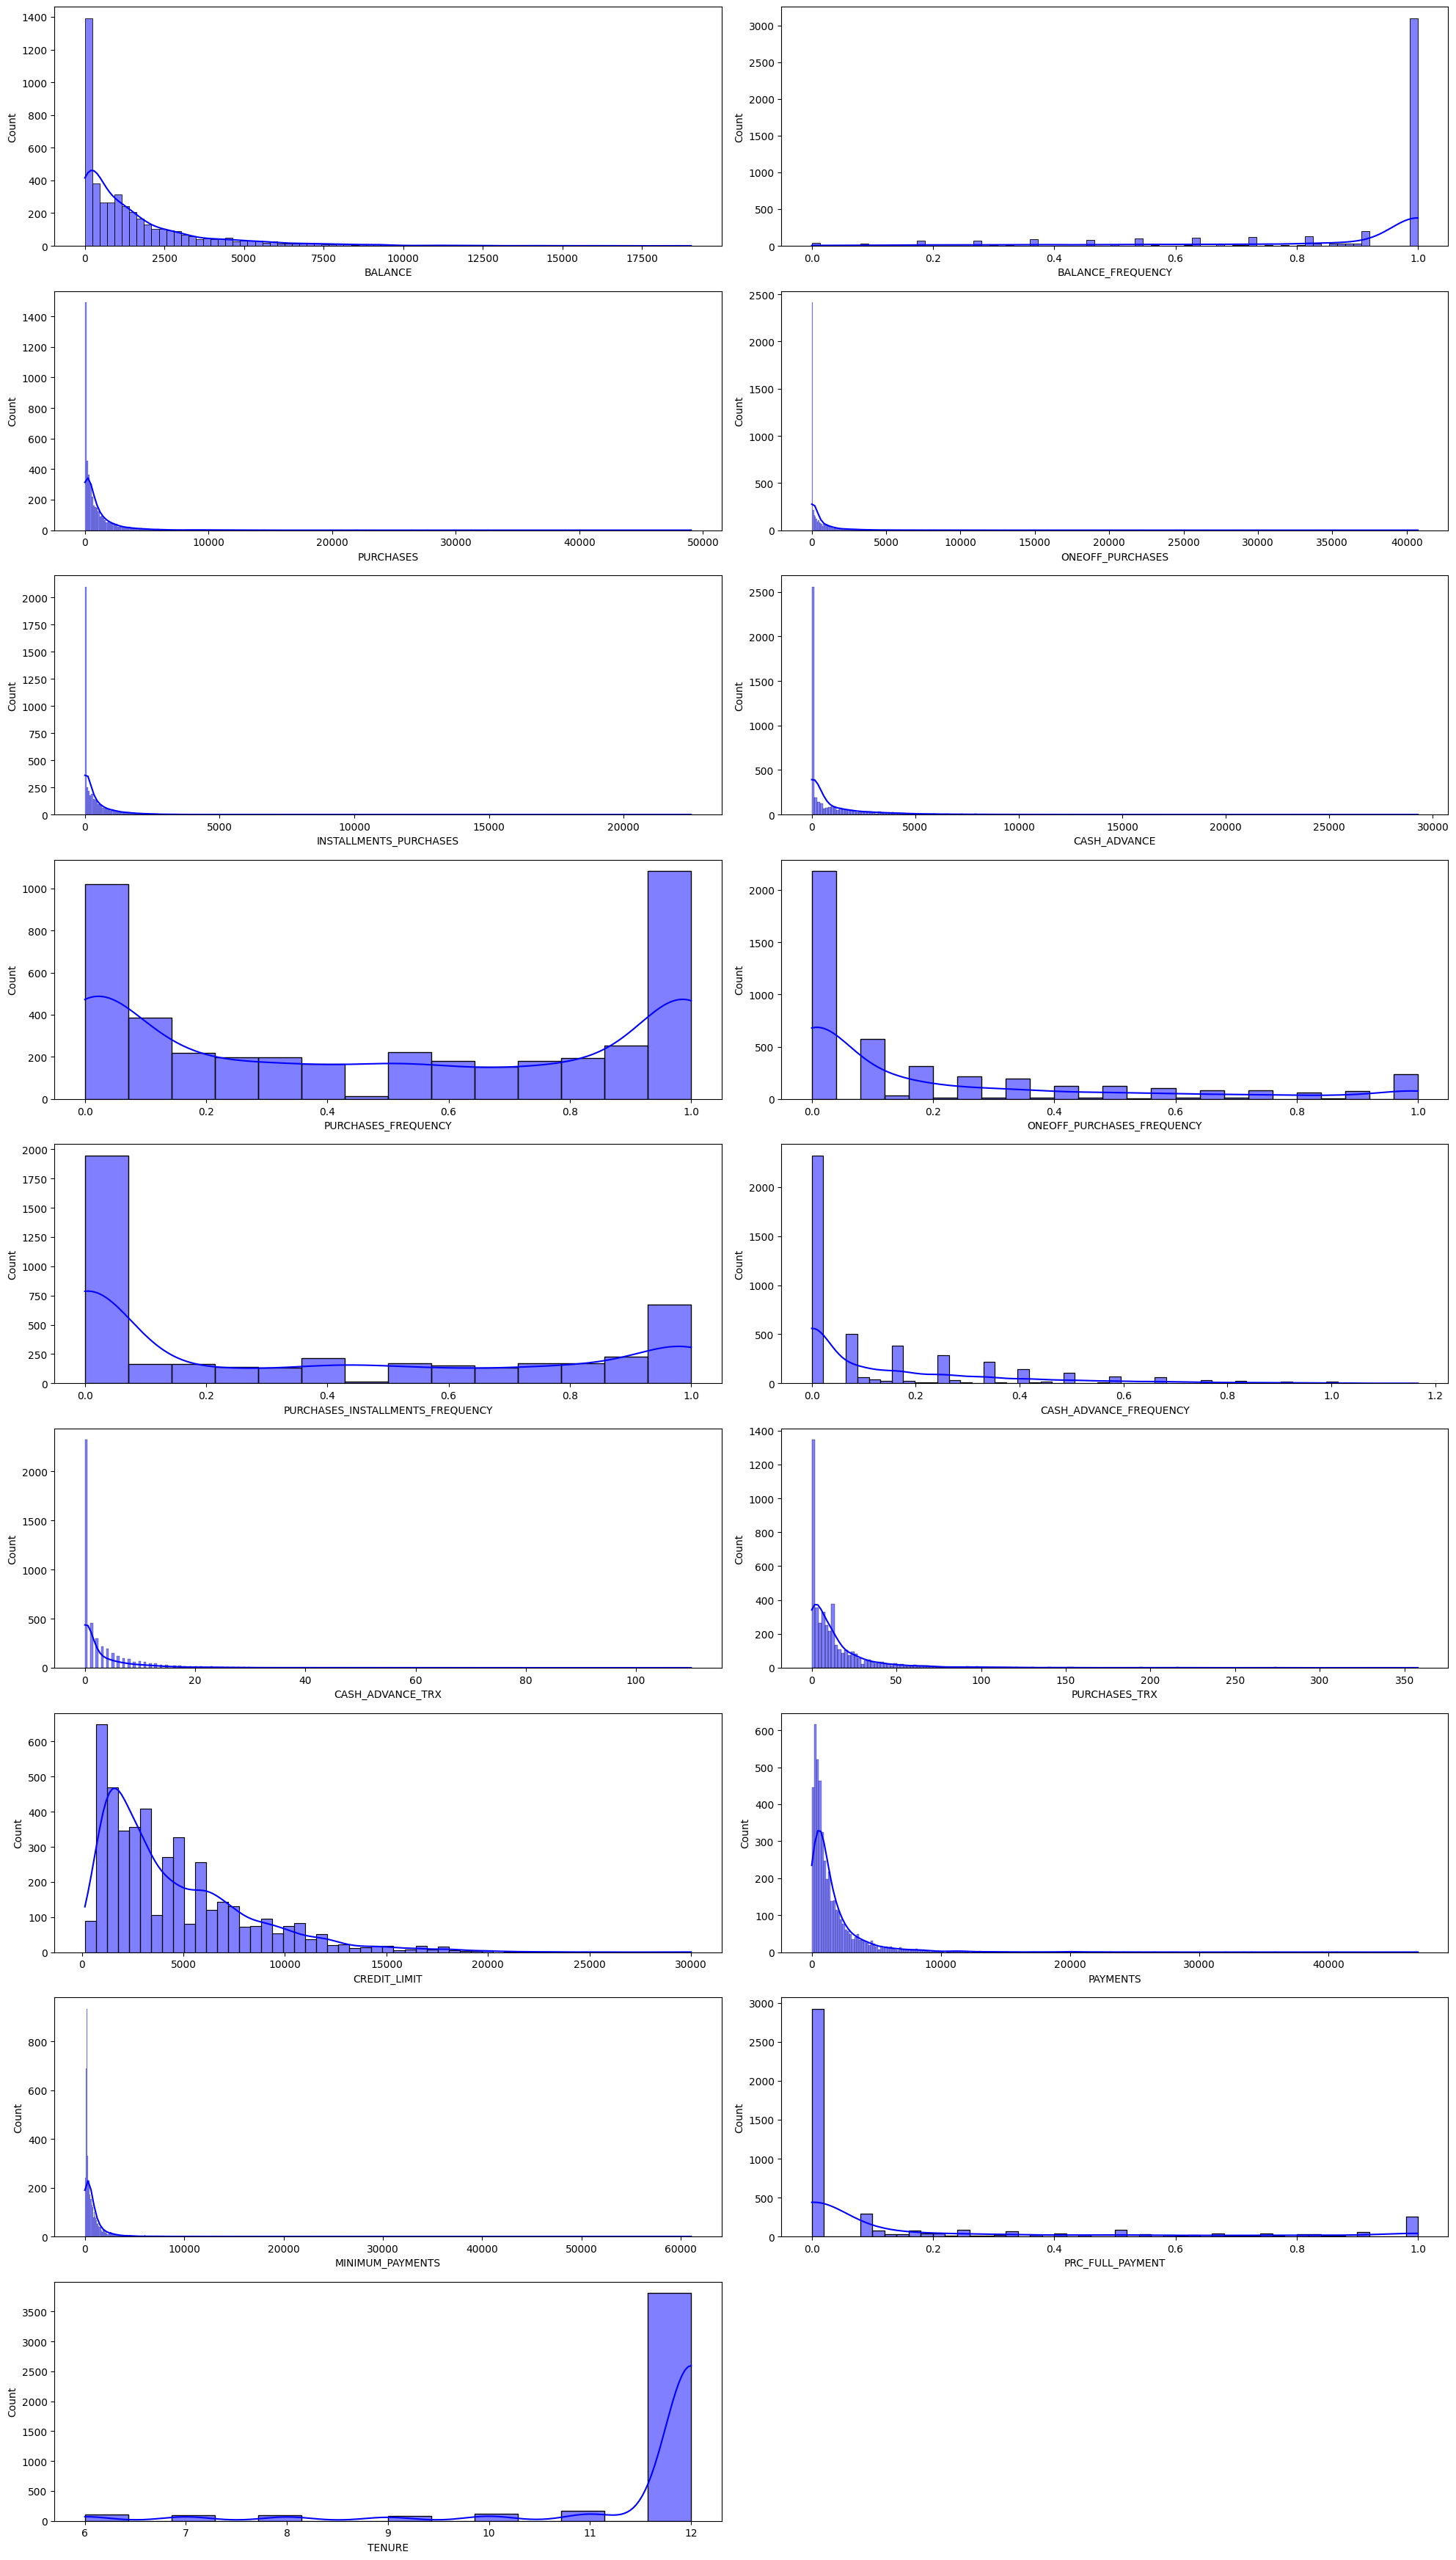

In [62]:
# membuat canvas untuk plot
plt.figure(figsize=(20, 35))

# Mengakses kolom mulai dari indeks ke-1
for i, col in enumerate(df.columns[1:], 1):  # Loop untuk semua kolom dari index 1 (kolom kedua)
    ax = plt.subplot(9, 2, i)  # Menentukan jumlah subplot, 9 baris, 2 kolom
    sns.histplot(df[col], kde=True, color="b")
    plt.xlabel(col)  # Menampilkan nama kolom sebagai label x

# menampilkan plot 
plt.tight_layout()
plt.show()

Dari output diatas didapatkan informasi bahwa:
- Kebanyakan nasabah memiliki credit limit dibawah 5000
- Dari behaviour pembayaran kartu kredit, kebanyakan nasabah melakukan pembayaran full payment dibandingkan minimum payment
- Dari behaviour pemakaian, pemakaian kartu kredit hampir merata dari cara pembayaran oneoff_purchase dan installment
- Untuk layanan cash_advance tidak terlalu digunakan oleh nasabah
- Distribusi data normal hanya ada pada kolom purchase_frequency 

## Melakukan Pengecekan Distribusi Data Kolom Numerik

In [63]:
# melakukan pengecekan skewness kolom numerical dataset menggunakan looping dan fungsi .skew()
for col in num_col:
    skewness = df[col].skew()
    print(f'Skewness kolom {col}: {skewness}')

Skewness kolom BALANCE: 2.456620962191608
Skewness kolom PURCHASES: 8.987051591977552
Skewness kolom ONEOFF_PURCHASES: 10.140058770209015
Skewness kolom INSTALLMENTS_PURCHASES: 8.116887369354234
Skewness kolom CASH_ADVANCE: 4.739677538274201
Skewness kolom CASH_ADVANCE_FREQUENCY: 1.8233800138256115
Skewness kolom CASH_ADVANCE_TRX: 4.75278000331602
Skewness kolom PURCHASES_TRX: 4.480452469147952
Skewness kolom CREDIT_LIMIT: 1.5450779677462632
Skewness kolom PAYMENTS: 6.040773400922328
Skewness kolom MINIMUM_PAYMENTS: 12.357860274482807
Skewness kolom PRC_FULL_PAYMENT: 1.9116495684046537
Skewness kolom BALANCE_FREQUENCY: -2.020309250153954
Skewness kolom PURCHASES_FREQUENCY: 0.06159754482450298
Skewness kolom ONEOFF_PURCHASES_FREQUENCY: 1.5234554787719887
Skewness kolom PURCHASES_INSTALLMENTS_FREQUENCY: 0.5102876658863782


Dari output diatas didapatkan informasi bahwa ada kolom yang distribusi datanya approximately symmetric dan highly skewed. Dari perbedaan tersebut selanjutnya akan dikelompokkan menjadi 2 variabel yang berbeda karena akan berbeda cara handlingnya.

In [64]:
# variabel dengan isi kolom yang distribusi datanya normal
approx_sym = ['PURCHASES_FREQUENCY']

# variabel dengan isi kolom yang distribusi datanya tidak normal
highly_skew = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']

## Missing Value

Pada bagian ini akan dilakukan analisa terkait jenis missing value pada kolom minimum_payments dan credit_limit

### Kolom Minimum Payment

Berdasarkan heatmap yang sebelumnya sudah dibuat, kolom minimum_payment memiliki korelasi paling tinggi dengan kolom balance, sehingga akan dilakukan pengecekan lebih lanjut untuk bisa menentukan jenis missing value pada kolom minimum_payment.

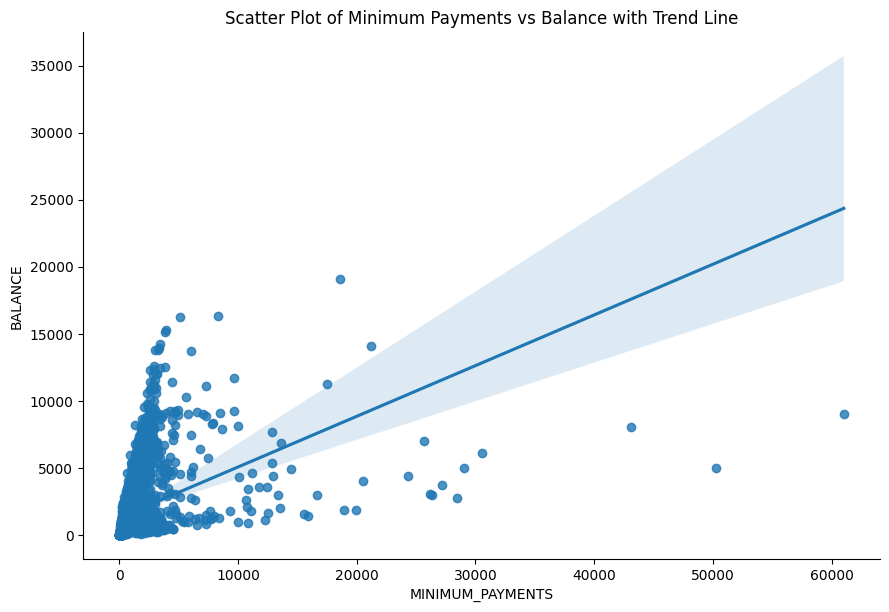

In [65]:
# Membuat scatterplot dengan trend line
sns.lmplot(data=df, x='MINIMUM_PAYMENTS', y='BALANCE', height=6, aspect=1.5)

# Menambah judul dan label sumbu
plt.title('Scatter Plot of Minimum Payments vs Balance with Trend Line')
plt.xlabel('MINIMUM_PAYMENTS')
plt.ylabel('BALANCE')

# menampilkan plot
plt.show()

Dari output diatas, didapatkan informasi bahwa kolom minimum_payments dan kolom balance memang memiliki korelasi positif, tetapi tidak bisa ditemukan pola yang pasti atas pembentukan korelasi ini, sehingga jenis missing value pada kolom minimum_payments akan dikonsedirasi sebagai jenis missing value MCAR.

### Kolom Credit Limit

Berdasarkan heatmap yang sebelumnya sudah dibuat, kolom credit_limit memiliki korelasi paling tinggi dengan kolom balance dan payments, sehingga akan dilakukan pengecekan lebih lanjut untuk bisa menentukan jenis missing value pada kolom minimum_payment.

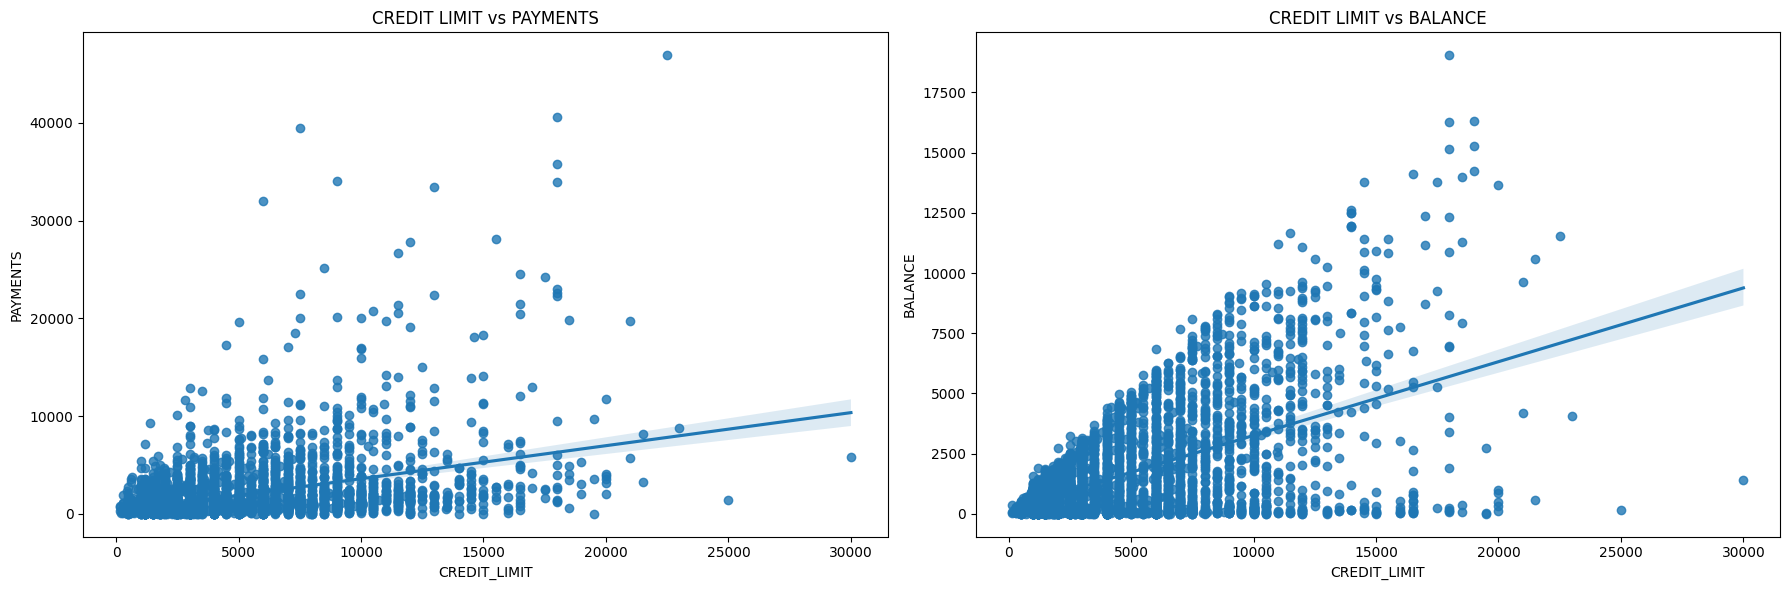

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plt.title('Scatter Plot of Minimum Payments vs Balance with Trend Line')
plt.xlabel('MINIMUM_PAYMENTS')
plt.ylabel('BALANCE')

# Scatter plot 1: TENURE vs PURCHASES
sns.regplot(data=df, x='CREDIT_LIMIT', y='PAYMENTS', ax=axes[0])
axes[0].set_title("CREDIT LIMIT vs PAYMENTS")

# Scatter plot 2: TENURE vs BALANCE
sns.regplot(data=df, x='CREDIT_LIMIT', y='BALANCE', ax=axes[1])
axes[1].set_title("CREDIT LIMIT vs BALANCE")

# Mengatur layout agar tidak tumpang tindih
plt.tight_layout()
plt.show()

Dari output diatas, didapatkan informasi bahwa kolom credit_limit dengan kolom balance dan payments memang memiliki korelasi positif, tetapi tidak bisa ditemukan juga pola yang pasti atas pembentukan korelasi ini, sehingga jenis missing value pada kolom credit limit akan dikonsedirasi sebagai jenis missing value MCAR.

## Pengaruh Tenure dengan Purchase, Balance, Payments

Melihat pengaruh tenure dengan kolom purchase, balance, dan payment dengan heatmap dan distribusi datanya.

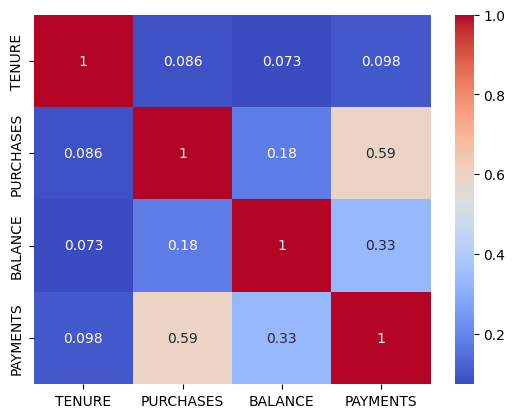

In [67]:
# Membuat heatmap
sns.heatmap(df[['TENURE', 'PURCHASES', 'BALANCE', 'PAYMENTS']].corr(), annot=True, cmap='coolwarm')

# menampilkan heatmap
plt.show()

Dari hasil heatmap kolom tenure tidak ada korelasi yang signifikan dengan kolom payments, balance, dan purchases. Tetapi akan dilihat lebih lanjut terkait distribusi datanya.

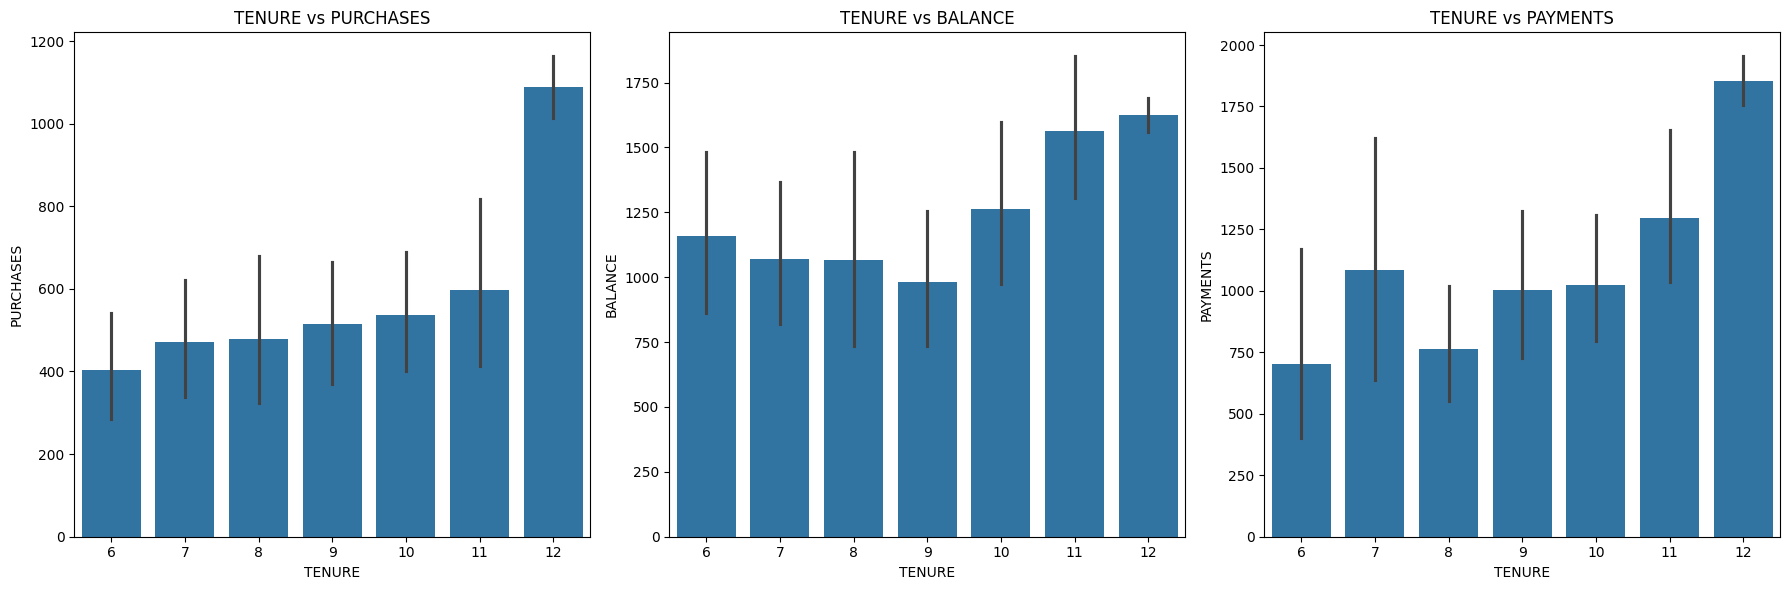

In [68]:
# Membuat figure dan axes untuk 3 plot dalam 1 row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot 1: TENURE vs PURCHASES
sns.barplot(data=df, x='TENURE', y='PURCHASES', ax=axes[0])
axes[0].set_title("TENURE vs PURCHASES")

# Scatter plot 2: TENURE vs BALANCE
sns.barplot(data=df, x='TENURE', y='BALANCE', ax=axes[1])
axes[1].set_title("TENURE vs BALANCE")

# Scatter plot 3: TENURE vs PAYMENTS
sns.barplot(data=df, x='TENURE', y='PAYMENTS', ax=axes[2])
axes[2].set_title("TENURE vs PAYMENTS")

# Mengatur layout agar tidak tumpang tindih
plt.tight_layout()

# menampilkan plot
plt.show()

Walaupun korelasinya positif dan tidak begitu kuat, ada beberapa insight yang bisa diambil:

- Nasabah yang mendapatkan tenure paling lama cenderung melakukan pembelian menggunakan kartu kredit dengan nominal yang besar
- Nasabah dengan balance diatas 1000 cenderung mendapatkan 3 layanan tenure paling lama
- Nasabah yang mendapatkan tenure paling lama harus dimaintain agar pembayaran kartu kreditnya tetap lancar

## Karakteristik nasabah yang memiliki credit limit yang besar dengan frequency pembelian

Melihat kecenderungan nasabah yang memiliki credit_limit besar apakah memiliki kecenderungan melakukan pembelian yang lebih besar juga menggunakan scatterplot

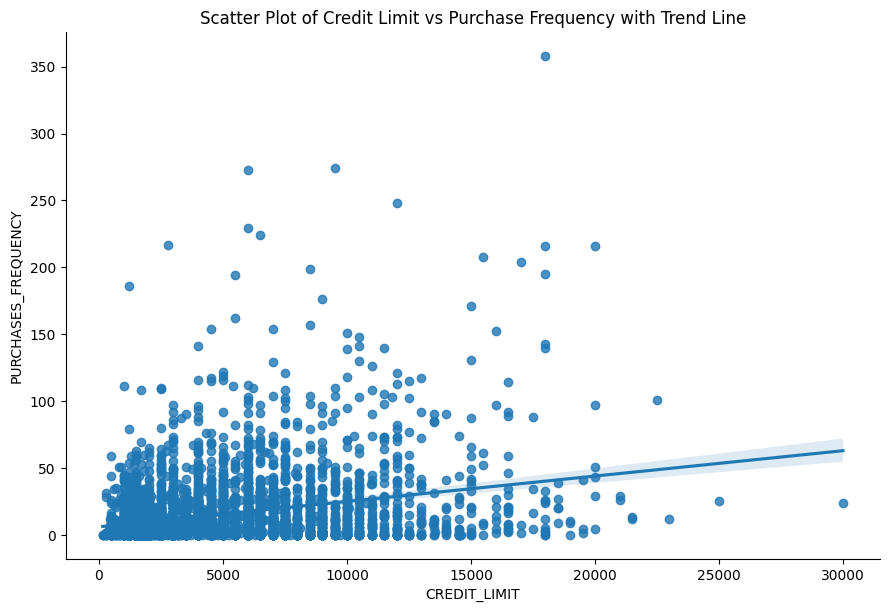

In [69]:
# Membuat scatterplot dengan trend line
sns.lmplot(data=df, x='CREDIT_LIMIT', y='PURCHASES_TRX', height=6, aspect=1.5)

# Menambah judul dan label sumbu
plt.title('Scatter Plot of Credit Limit vs Purchase Frequency with Trend Line')
plt.xlabel('CREDIT_LIMIT')
plt.ylabel('PURCHASES_FREQUENCY')

# menampilkan plot
plt.show()

Dari output diatas dapat disimpulkan bahwa credit limit dan purchase frequency menunjukkan korelasi positif, tetapi credit limit yang tinggi tidak selalu menghasilkan frekuensi pembelian yang tinggi. Cukup banyak pengguna dengan credit limit yang rendah atau sedang tetap memiliki frekuensi pembelian yang cukup aktif.

## Karakteristik nasabah yang memiliki credit limit yang besar dengan frequency cash advanced

Melihat kecenderungan nasabah yang memiliki credit_limit besar apakah memiliki kecenderungan sering melakukan cash_advance yang lebih besar juga menggunakan scatterplot

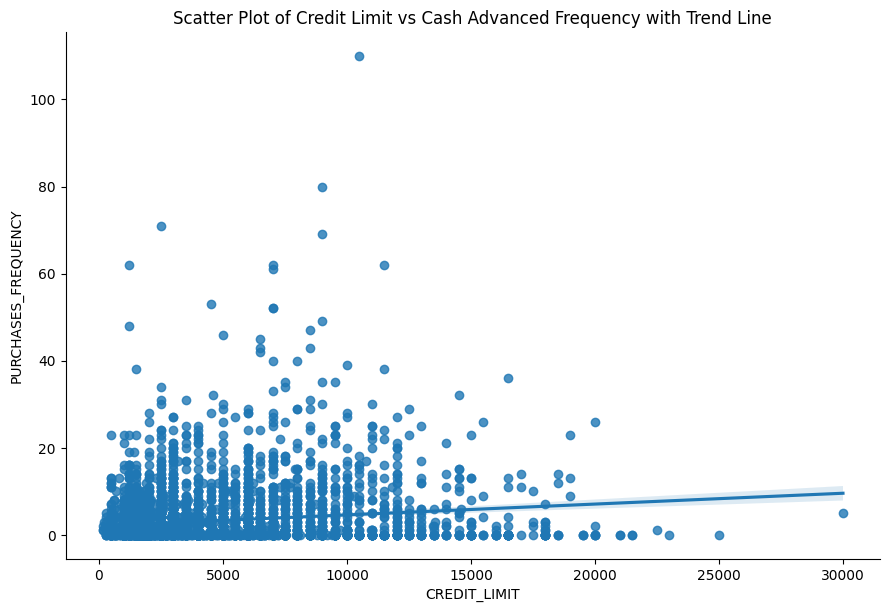

In [70]:
# Membuat scatterplot dengan trend line
sns.lmplot(data=df, x='CREDIT_LIMIT', y='CASH_ADVANCE_TRX', height=6, aspect=1.5)

# Menambah judul dan label sumbu
plt.title('Scatter Plot of Credit Limit vs Cash Advanced Frequency with Trend Line')
plt.xlabel('CREDIT_LIMIT')
plt.ylabel('PURCHASES_FREQUENCY')

# menampilkan plot
plt.show()

Dari output diatas dapat disimpulkan bahwa terdapat sedikit korelasi positif antara credit limit dan transaksi cash advance karena garis tren menunjukkan peningkatan yang sangat lemah. Ini berarti bahwa semakin tinggi batas kredit, cenderung ada sedikit peningkatan dalam transaksi cash advance.

# Feature Engineering

## Handling Missing Value

Dikarenakan jenis tipe missing value pada kolom minimum_payments dan credit_limit adalah MCAR, maka handling missing value pada kedua kolom tersebut menggunakan imputasi nilai median, karena kedua kolom tersebut distribusi datanya tidak normal.

In [71]:
# mencari nilai median kolom minimum_payments dan credit_limit
colss = ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']
for i in colss:
    med = df[i].median()
    df[i] = df[i].fillna(med)

## Handling Outliers

Untuk handling outliers akan digunakan metode capping berdasarkan distribusi data kolom numerikal yang sebelumnya sudah dianalisa.

In [72]:
def cek_outlier_skew(data, variable, distance):
    '''
    Fungsi ini dibuat untuk menghitung upper boundary dan lower boundary kolom numerik yang distribusi datanya tidak normal menggunakan perhitungan Tukey's Rule
    lalu dihitung persentasenya
    '''
    # tukey's rule
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)

    #menghitung persentase outlier dari data kolom
    outliers = data[(data[i] < lower_boundary) | (data[i] > upper_boundary)]
    total_observations = len(data[i])
    num_outliers = len(outliers[i])
    percentage_outliers = (num_outliers / total_observations) * 100

    # menampilkan output
    print(f'Kolom {i},\nUpper Boundary: {upper_boundary},\nLower Boundary:{lower_boundary},\nPersentase outlier kolom {i}: {percentage_outliers:.2f}%\n\n')

In [73]:
# melakukan looping data kolom numerik yang distribusinya tidak normal
for i in highly_skew:
    cek_outlier_skew(df, i, 3)

Kolom BALANCE,
Upper Boundary: 7836.467593,
Lower Boundary:-5645.412077,
Persentase outlier kolom BALANCE: 2.28%


Kolom PURCHASES,
Upper Boundary: 4370.365,
Lower Boundary:-3207.6599999999994,
Persentase outlier kolom PURCHASES: 4.07%


Kolom ONEOFF_PURCHASES,
Upper Boundary: 2321.28,
Lower Boundary:-1740.96,
Persentase outlier kolom ONEOFF_PURCHASES: 6.23%


Kolom INSTALLMENTS_PURCHASES,
Upper Boundary: 1937.02,
Lower Boundary:-1452.7649999999999,
Persentase outlier kolom INSTALLMENTS_PURCHASES: 4.11%


Kolom CASH_ADVANCE,
Upper Boundary: 4394.279848,
Lower Boundary:-3295.709886,
Persentase outlier kolom CASH_ADVANCE: 5.47%


Kolom CASH_ADVANCE_FREQUENCY,
Upper Boundary: 0.727272,
Lower Boundary:-0.545454,
Persentase outlier kolom CASH_ADVANCE_FREQUENCY: 2.35%


Kolom CASH_ADVANCE_TRX,
Upper Boundary: 16.0,
Lower Boundary:-12.0,
Persentase outlier kolom CASH_ADVANCE_TRX: 4.00%


Kolom PURCHASES_TRX,
Upper Boundary: 65.0,
Lower Boundary:-47.0,
Persentase outlier kolom PURCHASES_TRX: 3

Dari output diatas didapatkan keputusan bahwa kolom outlier cukup banyak sehingga akan dihandling dengan cara capping.

In [74]:
def cek_outlier_normal(data, variable, threshold=3):
    '''
    Fungsi ini dibuat untuk menghitung z-score dan mendeteksi outliers
    pada kolom numerik yang distribusi datanya normal.
    '''
    # Menghitung rata-rata dan standar deviasi
    mean = data[variable].mean()
    std = data[variable].std()

    # Menghitung z-score
    data['zscore'] = (data[variable] - mean) / std

    # Mendefinisikan outliers berdasarkan threshold
    outliers = data[np.abs(data['zscore']) > threshold]

    # Menghitung total observasi dan jumlah outliers
    total_observations = len(data)
    num_outliers = len(outliers)

    # Persentase outliers
    percentage_outliers = (num_outliers / total_observations) * 100

    # Hapus kolom zscore setelah perhitungan
    data.drop(columns=['zscore'], inplace=True)

    # Hasil perhitungan
    print(f'Kolom {variable},\nThreshold: {threshold},\nPersentase outliers: {percentage_outliers:.2f}%\n')

In [75]:
# melakukan looping data kolom numerik yang distribusinya normal
for i in approx_sym:
    cek_outlier_normal(df, i, 3)

Kolom PURCHASES_FREQUENCY,
Threshold: 3,
Persentase outliers: 0.00%



Dari hasil analisa sebelumnya, data yang distribusinya tidak normal akan dicapping menggunakan metode tukey's rule dan data yang distribusinya normal akan dicapping menggunakan metode z-score.

In [76]:
# capping menggunakan metode iqr(tukey's rule) Winsorizer 
winsoriser_numcols_skew = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=highly_skew)

# melakukan fit dan transform hasil capping ke dataset
df = winsoriser_numcols_skew.fit_transform(df)

In [77]:
# capping menggunakan metode gaussian(z-score) Winsorizer 
winsoriser_numcols_nor = Winsorizer(capping_method='gaussian',
                             tail='both',
                             fold=3,
                             variables=approx_sym)

# melakukan fit dan transform hasil capping ke dataset
df = winsoriser_numcols_nor.fit_transform(df)

## Scaling

Sebelum melakukan scaling, dataset yang sudah dihandling outlier dan missing valuenya dipisahkan berdasarkan tipe datanya. Selanjutnya akan dilakukan scalling menggunakan MinMaxScaler karena distribusi data sebelumnya banyak yang tidak normal.

In [78]:
# kolom numerikal
data_num_cols = df[num_col]

# kolom kategorikal
data_cat_cols = df[cat_col]

# mendefinisikan scaler
scaler = MinMaxScaler()

# melakukan fit dan transform scaling ke dataset
data_scaled = scaler.fit_transform(data_num_cols)

Setelah melakukan proses scaling, selanjutnya data akan direduksi fiturnya agar lebih mudah untuk dianalisa menggunakan model yang akan dipakai dalam clustering menggunakan PCA.

Text(0, 0.5, 'Eigenvalues')

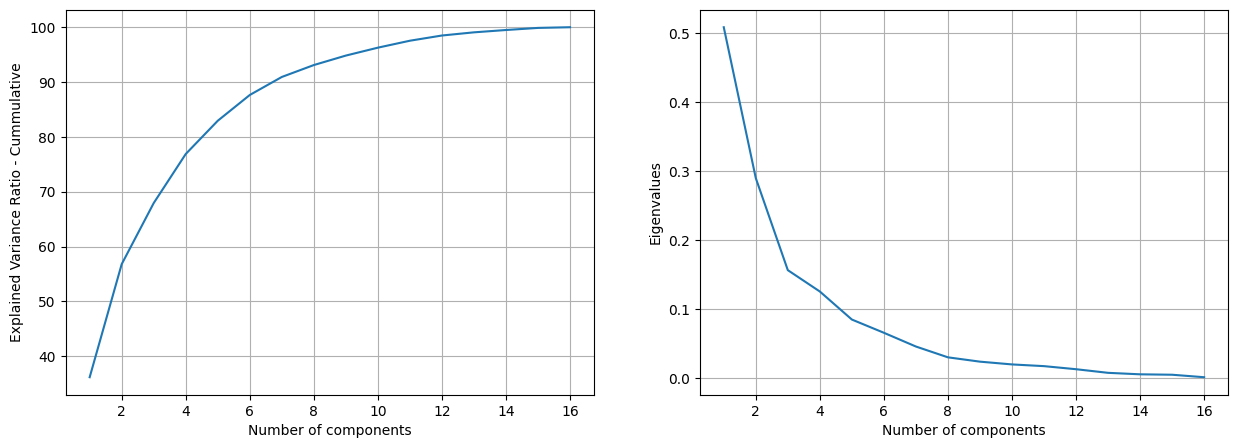

In [79]:
# mendefinisikan PCA
pca = PCA()

# melakukan fit PCA ke kolom yang sudah discaling
pca_data_scaled = pca.fit(data_scaled)

# membuat plot Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 17), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# membuat plot Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 17), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

Dari output diatas terlihat grafik dengan ratio informasi yang ingin dipertahankan sesuai dengan jumlah fiturnya. Selanjutnya ditentukan informasi yang ingin dipertahankan sebesar 90% sehingga fitur yang ingin dipakai adalah 7 fitur.

In [80]:
# melakukan pengecekan jumlah fitur jika ingin mempertahankan 90% informasi dataset
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.90) + 1
num_features

7

Dari output diatas, bisa dipastikan bahwa jumlah fitur yang akan digunakan setelah reduksi fitur adalah sebanyak **7 fitur**.

In [81]:
# melakukan PCA dengan 7 fitur
pca = PCA(n_components=7)

# melakukan fit PCA dengan 7 fitur ke data hasil scaling
pca.fit(data_scaled)

# melakukan transform PCA dengan 7 fitur ke data hasil scaling
data_scaled_pca = pca.transform(data_scaled)

## Elbow Method

Selanjutnya akan mencari jumlah cluster yang dibutuhkan untuk pemodelan clustering kali ini, mencari jumlah cluster yang tepat menggunakan elbow method dan membuat visualisasinya menggunakan silhouette plot.

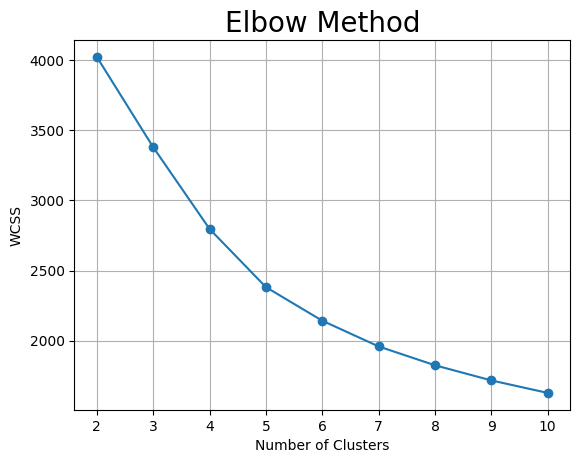

In [82]:
# membuat list kosong untuk menampung nilai inerteria
wcss = []

#mendefinisikan random state dan maksimal cluster yang diinginkan
random_state = 10
max_cluster = 10

# melakukan iterasi dari range 2 sampai 10
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(data_scaled_pca)
    wcss.append(km.inertia_)

# membuat plot
plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# menampilkan plot
plt.show()

Jumlah cluster yang bisa dipilih adalah sebanyak 3 atau 4 cluster. Tetapi asumsi kuat yang bisa dipilih adalah 3 cluster, karena garis grafik signifikan yang menurun terakhir terjadi saat jumlah cluster di titik 3 menuju titik 4.

## Silhouette Plot

Untuk memastikan berapa jumlah cluster yang bisa digunakan, selanjutnya dilakukan visualisasi menggunakan silhouete plot untuk melihat sebaran dan porsi data per cluster.

In [83]:
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.29363958016896263
For n_clusters = 3 The average silhouette_score is : 0.2512127307195286
For n_clusters = 4 The average silhouette_score is : 0.2658974505663822
For n_clusters = 5 The average silhouette_score is : 0.2868295636868978
For n_clusters = 6 The average silhouette_score is : 0.2937169004200556
For n_clusters = 7 The average silhouette_score is : 0.29094651909122193
For n_clusters = 8 The average silhouette_score is : 0.29250113173394887
For n_clusters = 9 The average silhouette_score is : 0.2962125124062015


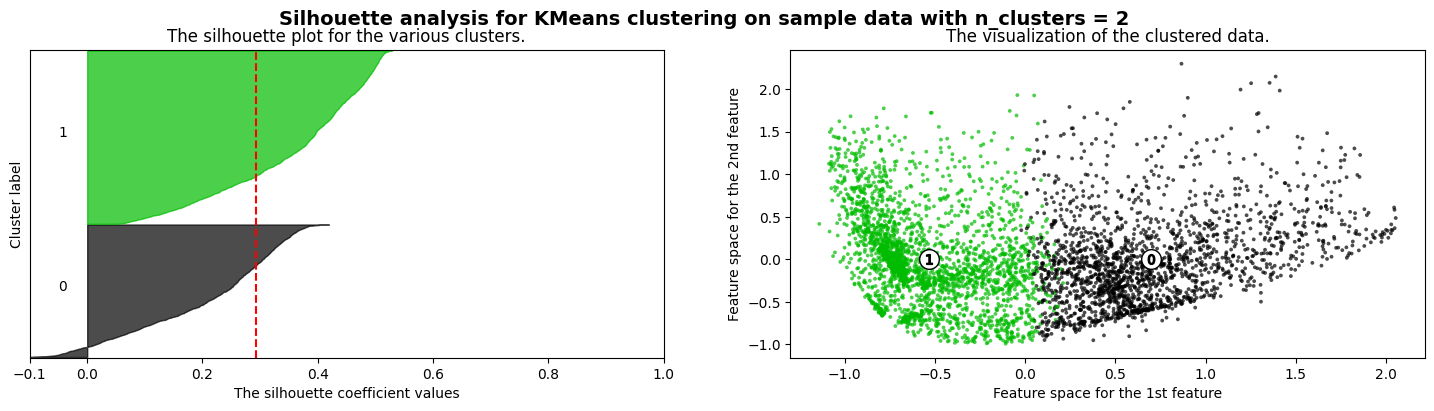

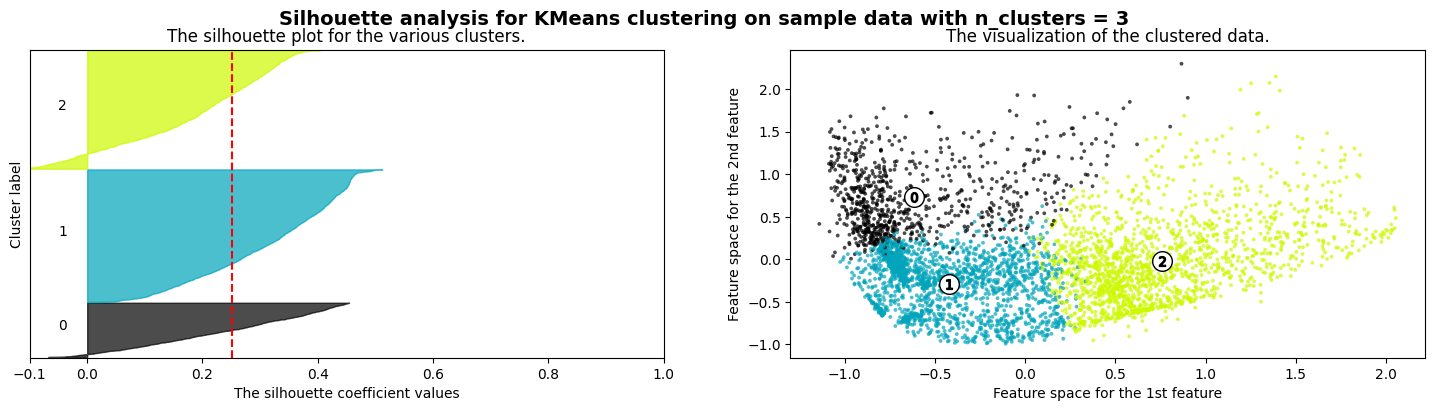

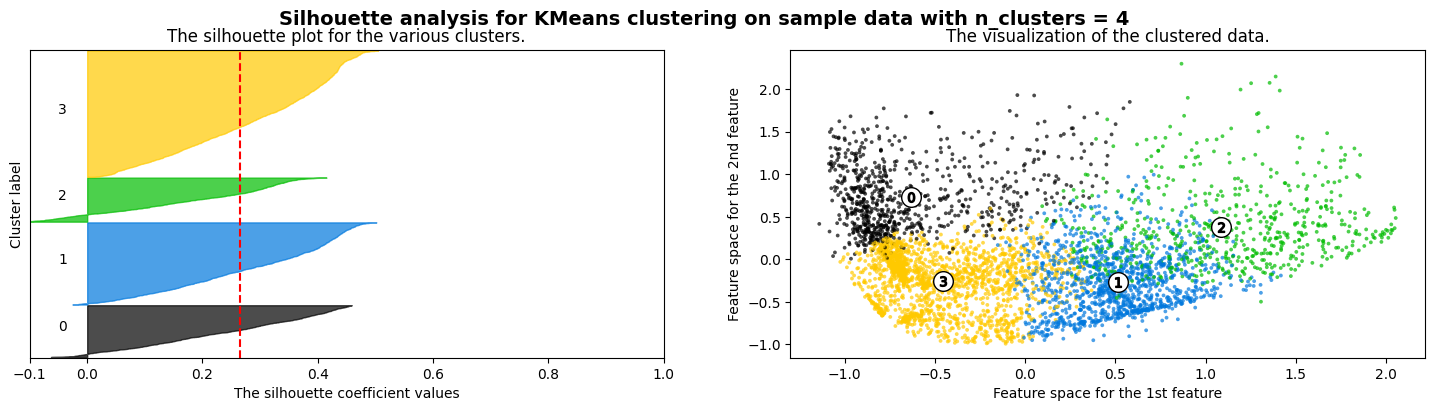

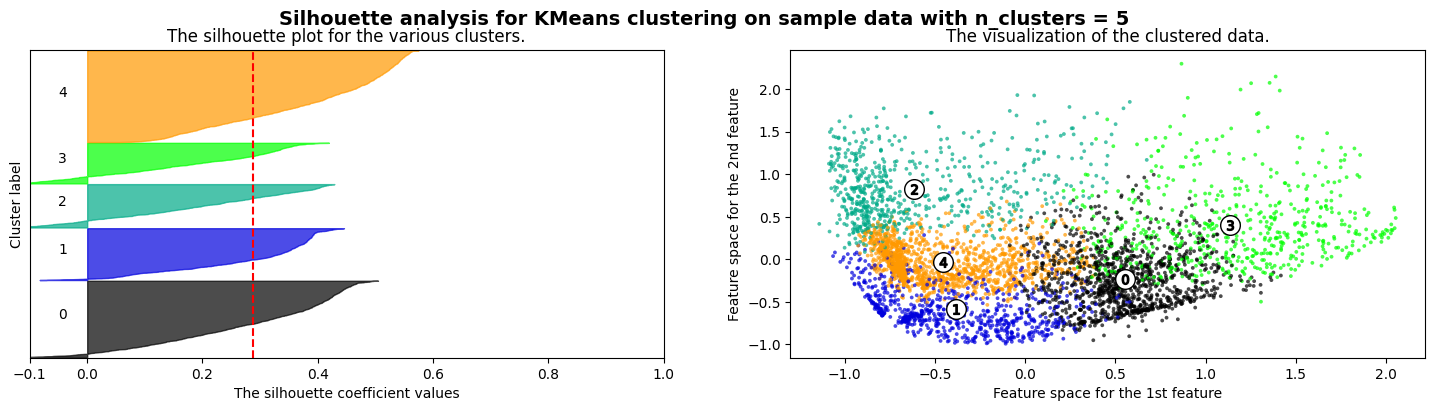

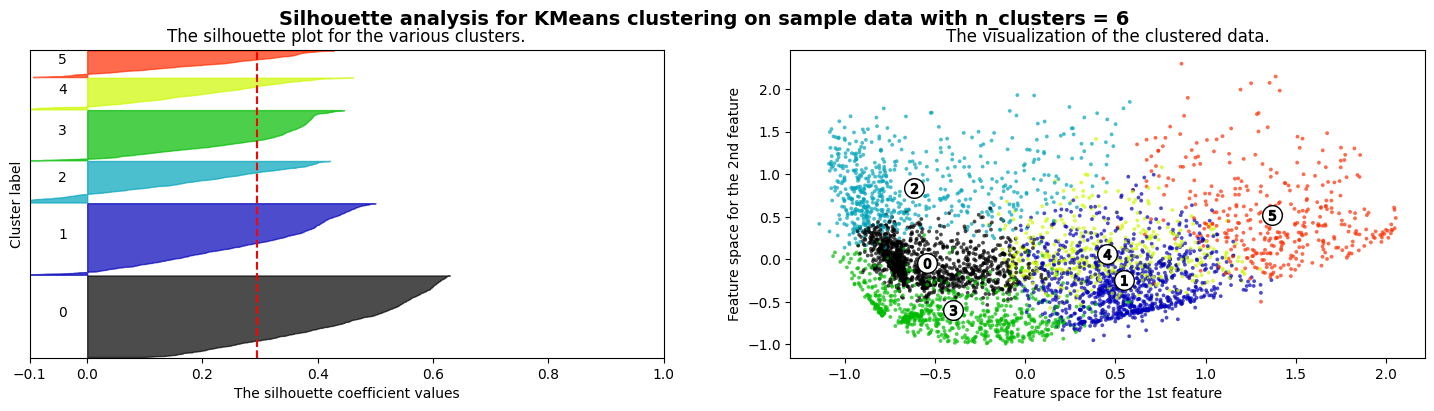

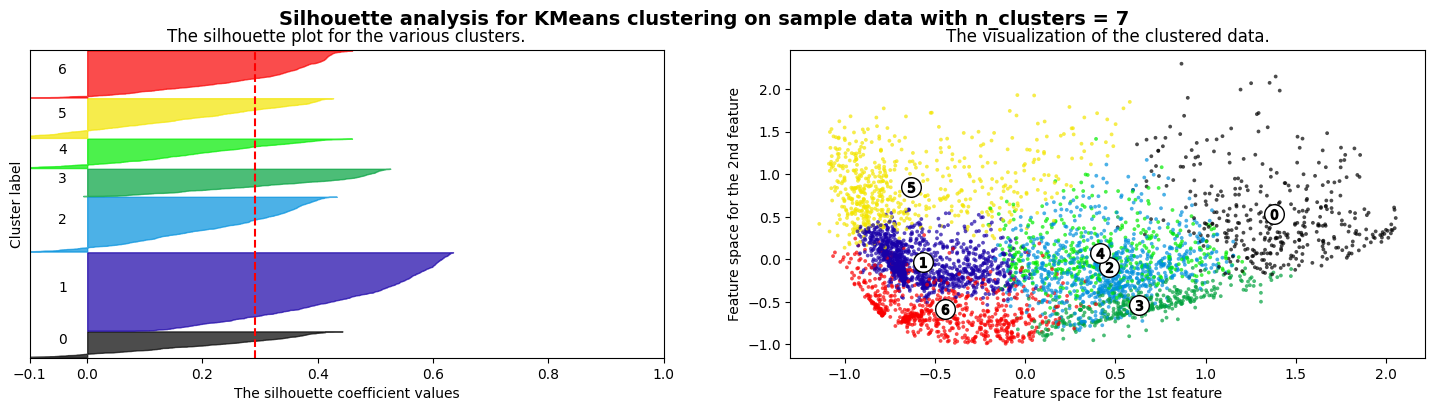

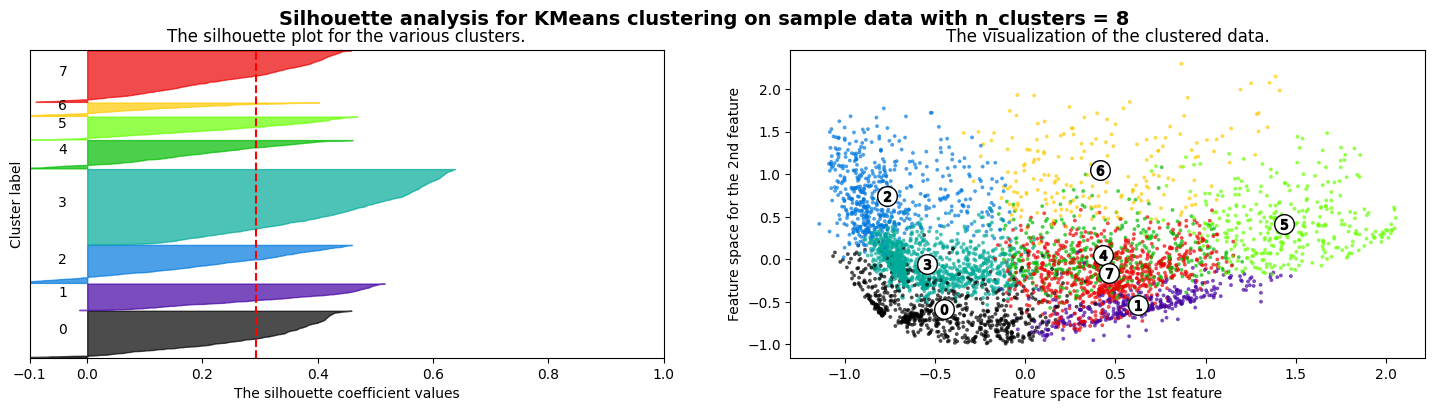

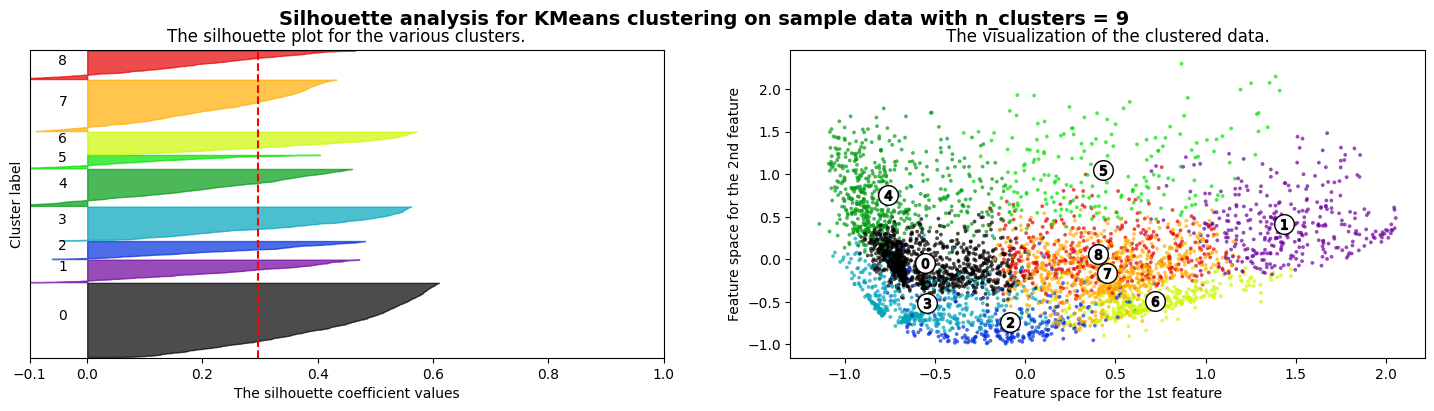

In [84]:
plot_silhouette(range(2, max_cluster), data_scaled_pca, random_state)

Karena sebelumnya ada pilihan dalam memilih jumlah cluster sebanyak 3 atau 4 yang terbaik, tetapi dengan hasil shilouette plot bisa ditarik kesimpulan bahwa dengan 4 cluster, banyak data dari cluster 1 yang overlapping dengan data cluster 2 dan 3. Lalu jika dilihat dengan 3 cluster, hasilnya lebih bisa mendefinisikan data masuk ke cluster yang mana, walaupun masih ada data yang overlapping, tetapi tidak sebanyak model dengan jumlah 4 cluster. Jadi bisa disimpulkan bahwa jumlah cluster yang optimal untuk clustering data kali ini adalah sebanyak 3 cluster.

# Model Definition

Pada program clustering ini akan digunakan model KMeans. Model ini digunakan karena cukup sederhana untuk digunakan dan dataset yang digunakan kebanyakan berisi data numerikal. Hyperparameter yang digunakan adalah jumlah cluster.

Metrics yang digunakan:
- Sebelum clustering: elbow method. Untuk memilih jumlah cluster yang optimal dengan cara melakukan plotting dari hasil nilai inerteria yang menghitung jarak antara titik-titik data dan titik centroid.
- Setelah clustering: silhouette scorenya. Untuk melihat seberapa tepat model bisa memasukkan data ke dalam suatu cluster.

Berdasarkan analisa jumlah cluster yang optimal untuk digunakan adalah 3 maka hyperparameter jumlah clusternya akan diset menjadi 3, tetapi akan dilakukan juga percobaan clustering menggunakan jumlah cluster sebanyak 4 cluster. Untuk jumlah fitur yang digunakan untuk model clustering jumlahnya sama, yaitu sebanyak 7 fitur atau sama dengan informasi data sebesar 90%. Untuk model dengan 3 cluster nilai rata-rata silhouette scorenya adalah 0.25, sedangkan model dengan 4 cluster nilai rata-rata silhouette scorenya adalah 0.26.

# Model Training

In [85]:
# Train model menggunakan 4 cluster
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

# melakukan fit dan predict data
pred1 = km.fit_predict(data_scaled_pca)

# copy dataset
df1= df.copy()

# menambahkan data hasil cluster
df1['cluster'] = pred1

In [86]:
# Train model menggunakan 3 cluster
km2 = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

# melakukan fit dan predict data
pred2 = km2.fit_predict(data_scaled_pca)

# copy dataset
df2= df.copy()

# menambahkan data hasil cluster
df2['cluster'] = pred2

# Model Evaluation

Pada bagian ini akan dilakukan evaluasi terhadap kedua model yang telah dibuat.

## Model dengan 4 Cluster

Melakukan visualisasi data dengan 4 cluster.

<Axes: >

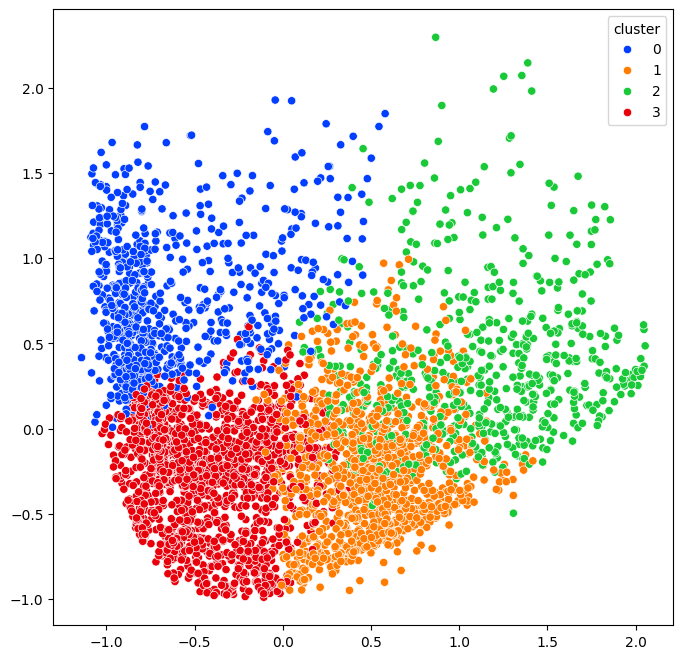

In [87]:
# Cluster visualization in 2D
pca_2d = PCA(n_components=2)
pca_2d.fit(data_scaled)

sales_scaled_pca_2d = pca_2d.fit_transform(data_scaled)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=sales_scaled_pca_2d[:,0], y=sales_scaled_pca_2d[:,1], hue=df1['cluster'], palette='bright')

Sama seperti asumsi sebelumnya, clustering dengan jumlah 4 cluster akan menyebabkan banyak data yang overlapping satu sama lain, seperti data cluster 2 dan 3 diatas.

Visualisasi proporsi jumlah customer per cluster:

In [88]:
# melakukan perhitungan jumlah nilai masing-masing kategori
cluster_count = df1.groupby('cluster').value_counts().to_frame()
cluster_count = cluster_count.reset_index()

# membuat pie chart menggunakan plotly
fig = px.pie(cluster_count, values='count', names='cluster', title='Proporsi 4 Cluster')
fig.update_layout(title_x = 0.5)

# menampilkan pie chart
fig.show()

Dari output diatas didapatkan hasil bahwa proporsi customer di cluster 1 dan 2 tidak bisa dipisahkan secara jelas karena banyak data yang overlapping antar cluster tersebut.

## Model dengan 3 Cluster

Melakukan visualisasi data dengan 3 cluster.

<Axes: >

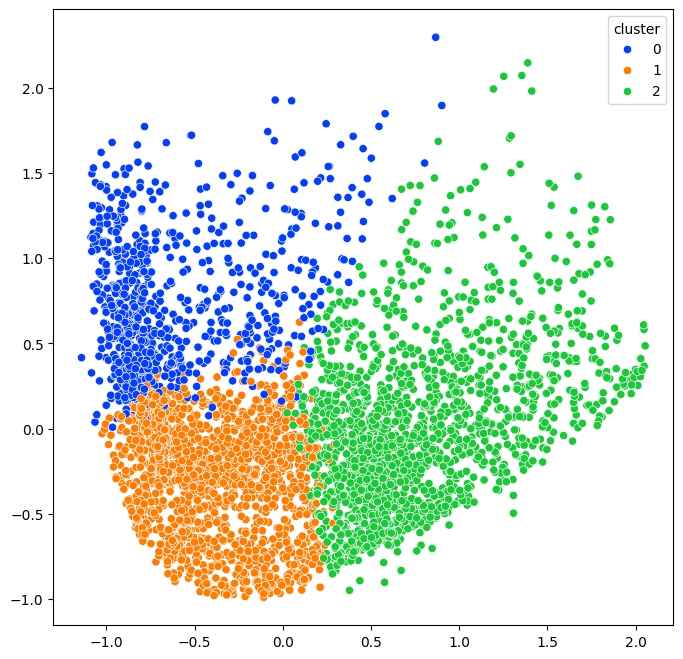

In [89]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(data_scaled)

sales_scaled_pca_2d = pca_2d.fit_transform(data_scaled)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=sales_scaled_pca_2d[:,0], y=sales_scaled_pca_2d[:,1], hue=df2['cluster'], palette='bright')

Dilihat dari output diatas, model clustering dengan jumlah 3 cluster akan menghasilkan data yang minim overlapping meskipun masih ada, tetapi tidak separah model 4 cluster. Meskipun jika dilihat dari visualisasi cluster 2 seharusnya bisa displit lagi tetapi dengan dataset yang ada jika displit menjadi 4 cluster akan menyebabkan overlapping seperti hasil visualisasi sebelumnya. Sehingga akan dilakukan analisa lebih lanjut menggunakan clustering sebanyak 3 cluster.

Visualisasi proporsi jumlah customer per cluster:

In [90]:
# melakukan perhitungan jumlah nilai masing-masing kategori
cluster_count = df2.groupby('cluster').value_counts().to_frame()
cluster_count = cluster_count.reset_index()

# membuat pie chart menggunakan plotly
fig = px.pie(cluster_count, values='count', names='cluster', title='Proporsi 3 Cluster')
fig.update_layout(title_x = 0.5)

# menampilkan pie chart
fig.show()

Meskipun hasil silhouette score model dengan 4 cluster lebih baik 0.01 dari model 3 cluster, dari output diatas didapatkan hasil bahwa proporsi customer di cluster 1 dan 2 bisa didefinisikan lebih baik meskipun masih ada data yang overlapping pada model dengan 3 cluster.

## Analisa Sebaran Data Masing-masing Cluster 

Analisa difokuskan dengan menggunakan 3 clustering. Analisa dilakukan menggunakan beberapa fitur yang ada untuk melihat karakteristik setiap cluster.

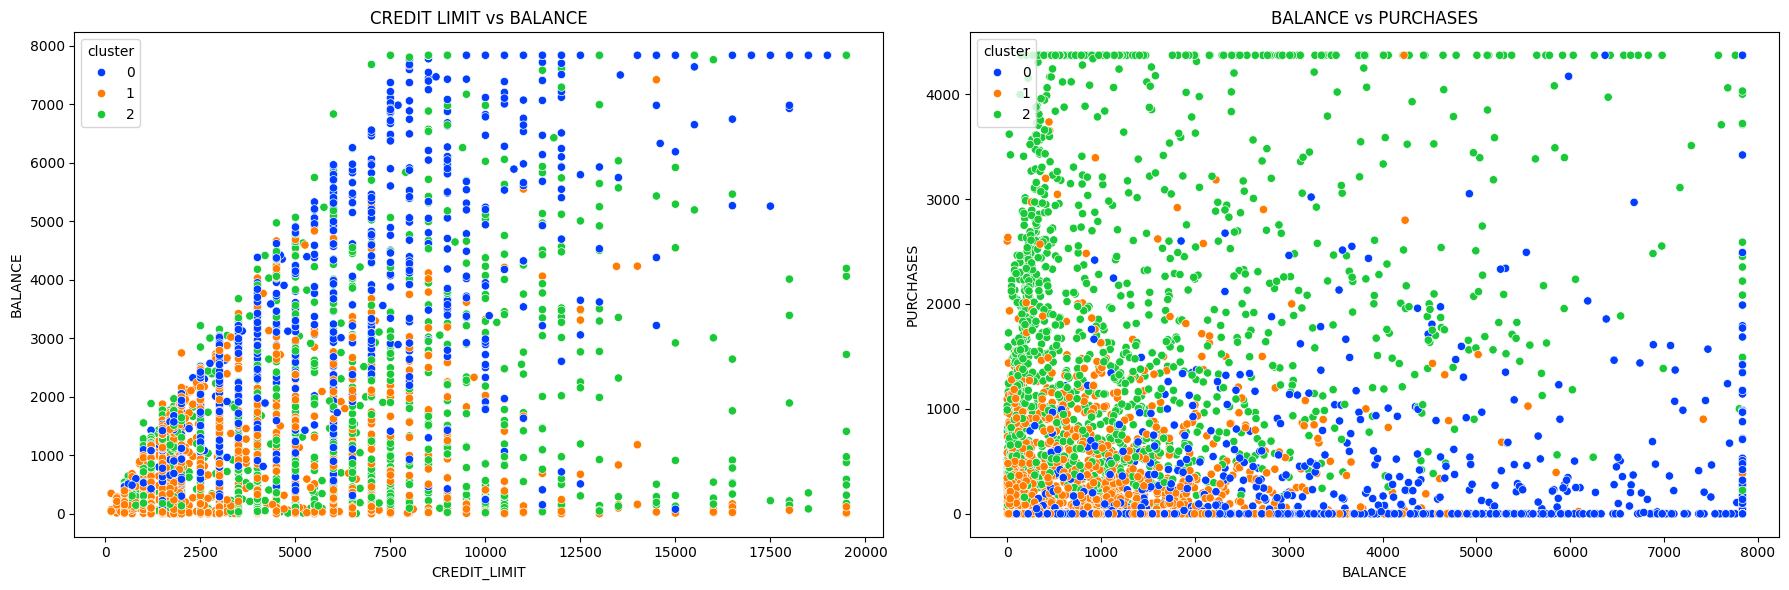

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# Scatter plot 1: CREDIT LIMIT vs BALANCE
sns.scatterplot(data=df2, x='CREDIT_LIMIT', y='BALANCE', hue="cluster",palette="bright", ax=axes[0])
axes[0].set_title("CREDIT LIMIT vs BALANCE")

# Scatter plot 2: BALANCE vs PURCHASES
sns.scatterplot(data=df2, x='BALANCE', y='PURCHASES', hue="cluster",palette="bright", ax=axes[1])
axes[1].set_title("BALANCE vs PURCHASES")

# Mengatur layout agar tidak tumpang tindih
plt.tight_layout()
plt.show()


Jika dilihat dari credit limit dan balance:
- **Cluster 0:** memiliki karakteristik jarang menggunakan kartu kredit, karena bisa dilihat dari plot cukup banyak sebaran data yang menunjukkan jika semakin besar credit_limit maka balancenya juga besar.
- **Cluster 1:** karakteristiknya hampir mirip dengan cluster 0, tetapi nasabah cluster 1 yang memiliki credit_limit besar cenderung lebih sering menggunakan kartu kredit sampai balancenya mendekati 0 sehingga cluster ini cocok untuk dijadikan target bisnis karena sering menggunakan kartu kredit
- **Cluster 2:** karakteristiknya hampir mirip dengan cluster 1 sehingga cluster ini juga bisa dijadikan target bisnis tambahan seperti cluster 1. Ditambah lagi credit_limit cluster ini cukup besar.

Jika dilihat dari balance dan purchases:
- **Cluster 0:** dari hasil plot ini menambah keyakinan bahwa cluster 0 cenderung jarang menggunakan kartu kredit untuk bertransaksi meskipun credit_limitnya besar
- **Cluster 1:** meskipun kredit limitnya tidak sebesar cluster 0, jumlah nilai pembelanjaan menggunakan kartu kredit lebih besar di cluster 1
- **Cluster 2:** pada cluster 2 cenderung menggunakan balance yang tersedia untuk melakukan transaksi. Semakin besar nasabah memiliki balance, maka nilai belanja menggunakan kartu kredit juga semakin besar. 

## Melihat Distribusi Data Masing-masing Cluster

Dibawah ini ditampilkan distribusi data masing-masing cluster menggunakan beberapa fitur yang tersedia.

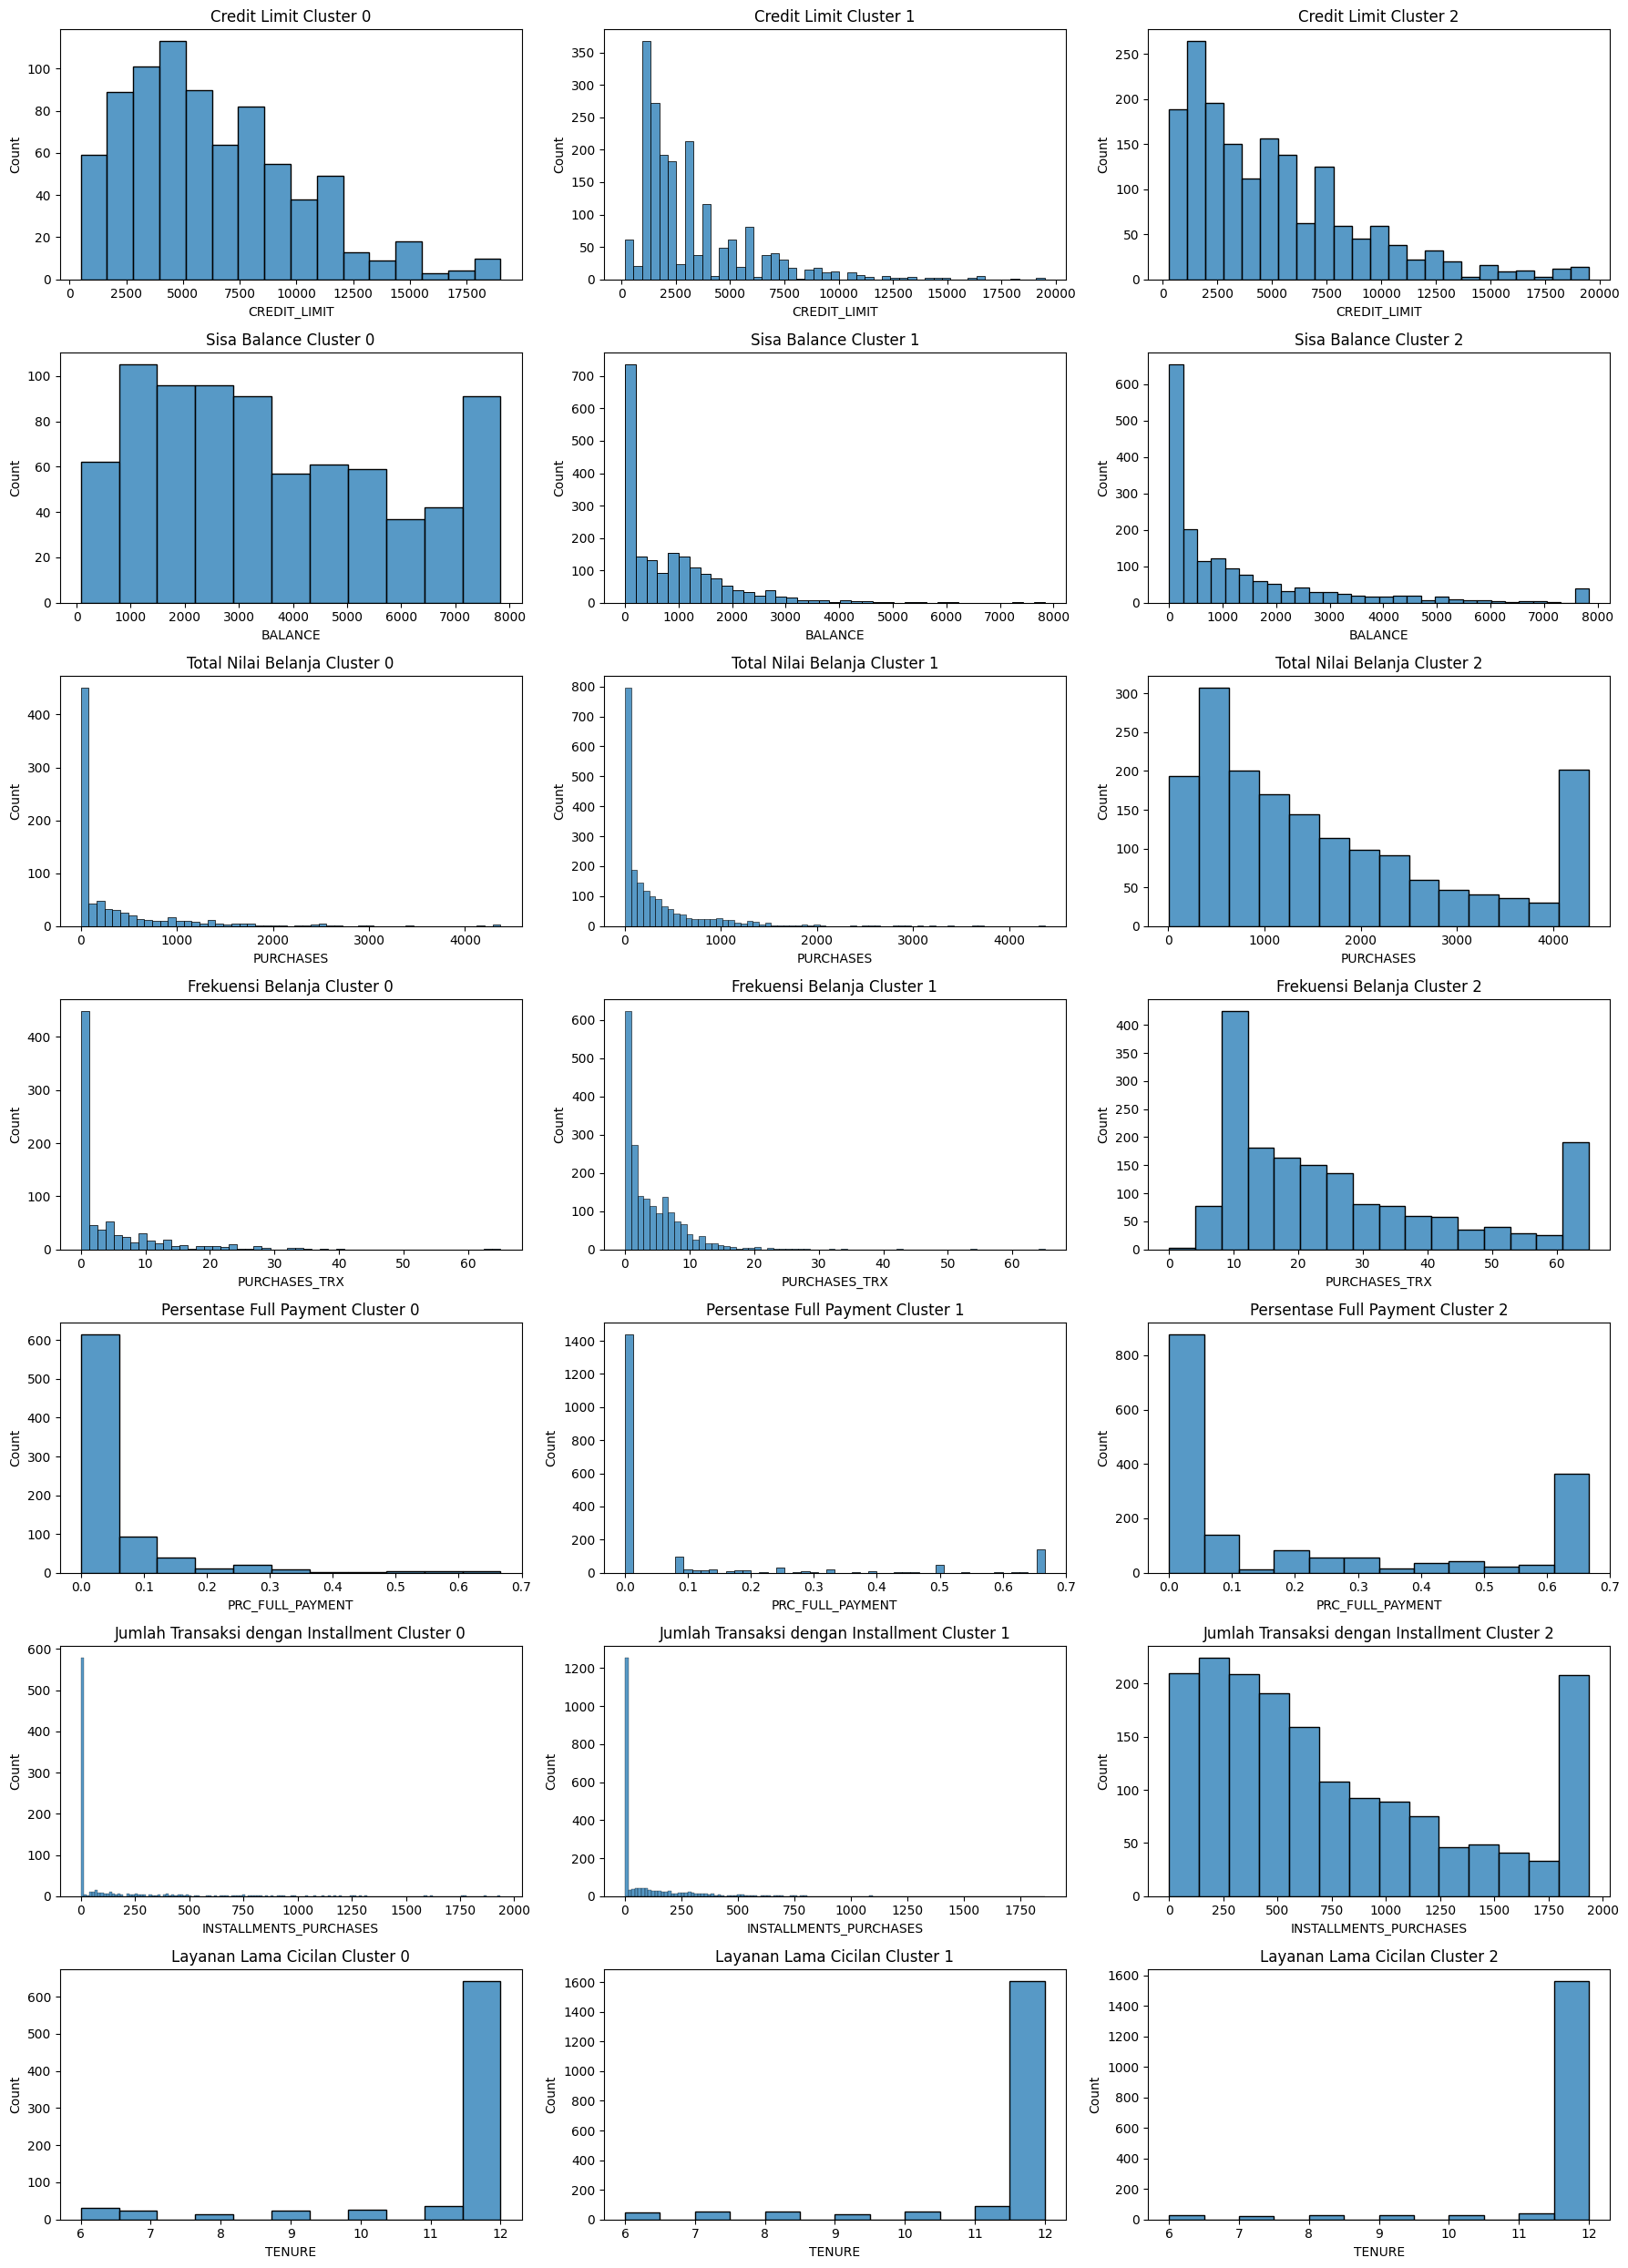

In [92]:
# Daftar kolom yang ingin dipetakan
columns = [
    ('CREDIT_LIMIT', 'Credit Limit'),
    ('BALANCE', 'Sisa Balance'),
    ('PURCHASES', 'Total Nilai Belanja'),
    ('PURCHASES_TRX', 'Frekuensi Belanja'),
    ('PRC_FULL_PAYMENT', 'Persentase Full Payment'),
    ('INSTALLMENTS_PURCHASES', 'Jumlah Transaksi dengan Installment'),
    ('TENURE', 'Layanan Lama Cicilan')
]

fig, axes = plt.subplots(7, 3, figsize=(18, 25))

# Looping untuk setiap cluster dan setiap kolom
for i, (col, title) in enumerate(columns):
    for cluster in range(3):
        ax = axes[i, cluster]
        sns.histplot(data=df2[df2['cluster'] == cluster], x=col, ax=ax)
        ax.set_title(f'{title} Cluster {cluster}')

plt.tight_layout()
plt.show()

Analisa tambahan berdasarkan output diatas:
- **Cluster 0:** meskipun cluster ini memiliki credit_limit yang besar, tetapi penggunaannya sangat minim jika dilihat dari grafik purchases dan purchases_trx dan balance yang tersedia, selain itu cluster 0 juga cenderung melakukan pembayaran dengan full payment dibandingkan dengan installment, hal tersebut bisa memicu nasabah yang memiliki kartu kredit untuk menutup kartu kredit jika dibiarkan. Namun masih ada nasabah di cluster ini yang memilih layanan dengan tenure 12.
- **Cluster 1:** meskipun kredit limitnya tidak sebesar cluster 0, cluster ini masih sering menggunakan kartu kredit untuk bertransaksi jika dilihat dari grafik purchases dan purchases_trx dan balance yang tersedia, meskipun banyak di cluster ini yang melakukan full payment, tetapi cluster 1 lebih banyak menggunakan installment dibandingkan cluster 0, sehingga dari temuan-temuan ini bisa diasumsikan kita masih bisa mempertahankan nasabah untuk tetap menggunakan kartu kredit. Selain itu nasabah di cluster ini banyak yang memilih layanan dengan tenure 12.
- **Cluster 2:** jika dilihat dari credit_limit yang dimiliki nasabah cluster ini, bisa disimpulkan bahwa cluster ini adalah target terbaik dalam strategi marketing dan pengembangan bisnis. Hal ini bisa dibuktikan dengan frekuensi belanja dan nominal belanja menggunakan kartu kredit yang besar, selain itu metode pembayarannya pun lebih banyak menggunakan installment sehingga kemungkinan nasabah cluster ini menutup kartu kredit sangat kecil. Selain itu nasabah di cluster ini banyak yang memilih layanan dengan tenure 12.

## Insight Model

Dari pemodelan clustering yang dilakukan menggunakan model KMeans didapatkan insight:
- Karena dataset ini bentuk datanya tidak teratur dan KMeans hanya baik jika menggunakan bentuk data yang spherical, maka model belum cukup baik untuk mendefinisikan cluster secara jelas untuk dataset ini. Tetapi masih bisa didapatkan karakteristik tiap cluster yang cukup jelas dari pemodelan ini
- Karakteristik setiap cluster lebih dikenali jika dilakukan visualisasi per fitur dari masing-masing cluster, dibandingkan melakukan visualisasi dengan beberapa fitur
- Karena cukup banyak outlier sehingga model ini juga kurang cocok digunakan untuk dataset ini.
- Karena modelnya kurang baik mengakibatkan proses clustering akan sedikit bias karena ada data yang overlap.

## Rekomendasi Model

Karena dataset ini bentuknya tidak teratur dan banyak outlier, bisa dicoba untuk melakukan clustering menggunakan model yang lain, misalnya DBSCAN agar bisa mendapatkan hasil clustering yang tepat, sehingga rekomendasi bisnis yang diberikan bisa lebih tepat sasaran pula.

# Model Saving

In [93]:
#Save Files

with open('list_num_col.txt', 'w') as file_1:
  json.dump(num_col, file_1)

with open('scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('pca.pkl', 'wb') as file_3:
  pickle.dump(pca, file_3)

with open('kmeans.pkl', 'wb') as file_4:
  pickle.dump(km2, file_4)

# Pengambilan Kesimpulan

## Analisa Karakteristik per Cluster

**Cluster 0:**
- Credit limit tergolong high, karena tidak ada fitur data pekerjaan dan penghasilan maka asumsinya pemilik kartu kredit ini adalah pengusaha atau pekerja yang memiliki pendapatan besar
- Balance kartu kredit besar, karena memiliki pendapatan yang besar, para pemilik kartu ini jarang menggunakan kartu kredit dan lebih memilih melakukan pembelian menggunakan tunai atau debit
- Jarang melakukan transaksi
- Nominal transaksi kecil
- Lebih sering melakukan full payment
- Jarang menggunakan installment meskipun ada yang memilih layanan tenure hingga 12
- Jumlah nasabah yang ada di cluster ini paling sedikit, sebanyak 797 nasabah dengan porsi 17.8% dari keseluruhan nasabah

**Cluster 1:**
- Credit limit tergolong medium to low, karena tidak ada fitur data pekerjaan dan penghasilan maka asumsinya pemilik kartu kredit ini adalah karyawan swasta yang baru mendapatkan fasilitas kartu kredit karena limitnya tidak besar seperti cluster 0
- Balance kartu kredit cukup kecil, artinya dari limit credit yang diberikan di cluster ini sering bertransaksi menggunakan kartu kredit
- Cukup sering melakukan transaksi
- Nominal transaksi cukup besar
- Ada yang jarang melakukan full payment
- Beberapa ada yang menggunakan installment dan tenur yang dipilih banyak yang 12
- Jumlah nasabah yang ada di cluster ini paling banyak, sebanyak 1944 nasabah dengan porsi 43.4% dari keseluruhan nasabah

**Cluster 2:**
- Credit limit lebih banyak digolongkan medium to low, tetapi ada yang medium to high, karena tidak ada fitur data pekerjaan dan penghasilan maka asumsinya pemilik kartu kredit ini adalah karyawan swasta yang sudah lumayan lama menggunakan kartu kredit
- Balance kartu kredit cukup kecil, artinya dari limit credit yang diberikan di cluster ini sering bertransaksi menggunakan kartu kredit
- Sering melakukan transaksi
- Nominal transaksi besar
- Cukup sering melakukan full payment
- Banyak yang menggunakan installment dan pilihan tenurenya adalah 12, artinya di cluster ini memiliki kecenderungan sifat konsumtif
- Jumlah nasabah yang ada di cluster hampir mirip dengan cluster 1, yaitu sebanyak 1734 nasabah dengan porsi 38.7% dari keseluruhan nasabah

## Rekomendasi Bisnis per Cluster

Fokus utamanya adalah meningkatkan transaksi dan mempertahankan transaksi dari nasabah yang masuk kedalam cluster 1 dan cluster 2, tetapi tidak juga melupakan cluster 0. Cluster 1 dan cluster 2 menjadi fokus utama karena nasabah yang sering menggunakan kartu kredit ada pada cluster ini.

**Cluster 0:**
- Memberikan penawaran untuk pembelian barang elektronik rumah dengan promo cicilan bunga 0% di tenor 12 bulan untuk mempertahankan nasabah di cluster ini tetap menggunakan kartu kredit
- Memberikan edukasi penggunaan kartu kredit dan memberikan penawaran dengan menggunakan sistem cold-calling dan email marketing
- Memberikan poin loyalti disetiap transaksi dan pembayaran tagihan kartu kredit, lalu poin tersebut bisa ditukarkan dengan voucher diskon ditransaksi selanjutnya atau menjadi poin yang bisa dikonversi sebagai potongan harga secara langsung saat bertransaksi menggunakan kartu kredit

**Cluster 1:**
- Meningkatkan credit limit nasabah yang kolektabilitasnya bagus
- Memberikan promo diskon potongan tenure 1 bulan jika pembelian menggunakan installment tenure 12 untuk pembelanjaan kategori elektronik menggunakan kartu kredit
- Memberikan promo payday buy 1 get 1 disetiap akhir bulan setiap bertransaksi menggunakan kartu kredit
- Menurunkan minimal nominal transaksi untuk menggunakan layanan installment kartu kredit
- Menambah jangka waktu tenure misalnya menjadi 15 dan 18 bulan untuk minimal nominal transaksi diatas 5.000.000
- Memberikan poin loyalti disetiap transaksi dan pembayaran tagihan kartu kredit, lalu poin tersebut bisa ditukarkan dengan voucher diskon ditransaksi selanjutnya atau menjadi poin yang bisa dikonversi sebagai potongan harga secara langsung saat bertransaksi menggunakan kartu kredit

**Cluster 2:**
- Meningkatkan credit limit nasabah yang kolektabilitasnya bagus
- Memberikan promo promo cicilan bunga 0% di tenor 12 bulan untuk kategori apa saja
- Memberikan promo payday buy 1 get 1 disetiap akhir bulan setiap bertransaksi menggunakan kartu kredit
- Menurunkan minimal nominal transaksi untuk menggunakan layanan installment kartu kredit
- Menambah jangka waktu tenure misalnya menjadi 18 bulan untuk minimal nominal transaksi diatas 5.000.000
- Memberikan poin loyalti disetiap transaksi dan pembayaran tagihan kartu kredit, lalu poin tersebut bisa ditukarkan dengan voucher diskon ditransaksi selanjutnya atau menjadi poin yang bisa dikonversi sebagai potongan harga secara langsung saat bertransaksi menggunakan kartu kredit